# Certificate in Data Analytics for Finance
## Final Project
### Predicting and Analysing the 2022 World Cup
#### Michael Mallon

In [1]:
## Importing Dependancies

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od

from bs4 import BeautifulSoup 
import requests   
import time
import csv

import seaborn as sns
import random
from scipy.stats import norm

### Loading Data in from Kaggle API

In [2]:
od.download("https://www.kaggle.com/datasets/cashncarry/fifaworldranking")

Skipping, found downloaded files in "./fifaworldranking" (use force=True to force download)


### Reading in the Kaggle tables from dataset

In [3]:
fifarankingdata = (r'/Users/mallon/Desktop/UCD Data Analytics for Finance/fifaworldranking/fifa_ranking-2022-10-06.csv')
fifarankings= pd.read_csv(fifarankingdata)

In [4]:
## Taking only the max entry (as many historical exist) - could be used in future development
### Filtering table down
max_date = fifarankings['rank_date'].max()
fifarankings = fifarankings[fifarankings['rank_date'].isin([max_date])]
fifarankings = fifarankings[['rank', 'country_full','country_abrv']]

In [5]:
## Quick look at the df
fifarankings.sort_values('rank',ascending=True).head(5)

,rank,country_full,country_abrv
63809,1,Brazil,BRA
63838,2,Belgium,BEL
63839,3,Argentina,ARG
63840,4,France,FRA
63841,5,England,ENG


## EA Sports FIFA Ratings

### Loading Data in from Kaggle API

f51999f5f297523ab16349d4112bd4ff

In [6]:
od.download("https://www.kaggle.com/datasets/sanjeetsinghnaik/fifa-23-players-dataset")

Skipping, found downloaded files in "./fifa-23-players-dataset" (use force=True to force download)


### Reading in the Kaggle tables from dataset

In [7]:
fifa23data = (r'/Users/mallon/Desktop/UCD Data Analytics for Finance/fifa-23-players-dataset/Fifa 23 Players Data.csv')
fifa23= pd.read_csv(fifa23data)

In [8]:
# Teams in the World Cup
WC_2022_teams = ['Qatar', 'Germany', 'Denmark', 'Brazil', 'France', 'Belgium', 'Croatia', 'Spain', 'Serbia', 'England', 'Switzerland', 'Netherlands', 'Argentina', 'Iran', 'Korea Republic', 'Japan', 'Saudi Arabia', 'Ecuador', 'Uruguay', 'Canada', 'Ghana', 'Senegal', 'Portugal', 'Poland', 'Tunisia', 'Morocco', 'Cameroon', 'United States', 'Mexico', 'Wales', 'Australia', 'Costa Rica']

In [9]:
# Filtering on WC team
fifa23 = fifa23[fifa23["Nationality"].isin(WC_2022_teams)]

In [10]:
# A Quick Look into the Dataset
fifa23.head(5)

,Known As,Full Name,Overall,Potential,Value(in Euro),Positions Played,Best Position,Nationality,Image Link,Age,...,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
0,L. Messi,Lionel Messi,91,91,54000000,RW,CAM,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,35,...,91,88,91,67,66,67,62,53,62,22
1,K. Benzema,Karim Benzema,91,91,64000000,"CF,ST",CF,France,https://cdn.sofifa.net/players/165/153/23_60.png,34,...,89,84,89,67,67,67,63,58,63,21
2,R. Lewandowski,Robert Lewandowski,91,91,84000000,ST,ST,Poland,https://cdn.sofifa.net/players/188/545/23_60.png,33,...,86,83,86,67,69,67,64,63,64,22
3,K. De Bruyne,Kevin De Bruyne,91,91,107500000,"CM,CAM",CM,Belgium,https://cdn.sofifa.net/players/192/985/23_60.png,31,...,91,91,91,82,82,82,78,72,78,24
4,K. Mbappé,Kylian Mbappé,91,95,190500000,"ST,LW",ST,France,https://cdn.sofifa.net/players/231/747/23_60.png,23,...,92,84,92,70,66,70,66,57,66,21


In [11]:
fifa23.describe()

,Overall,Potential,Value(in Euro),Age,Height(in cm),Weight(in kg),TotalStats,BaseStats,Wage(in Euro),Release Clause,...,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
count,11611.000000,11611.000000,1.161100e+04,11611.000000,11611.000000,11611.000000,11611.000000,11611.000000,11611.000000,1.161100e+04,...,11611.000000,11611.000000,11611.000000,11611.000000,11611.000000,11611.000000,11611.000000,11611.000000,11611.000000,11611.000000
mean,66.482818,71.760830,3.369115e+06,25.121264,181.653777,75.260357,1613.349668,360.602532,10285.642925,6.009883e+06,...,58.936353,57.942727,58.936353,56.767720,56.490483,56.767720,56.117992,55.029024,56.117992,23.458272
std,6.787251,6.111206,8.595532e+06,4.708627,6.900113,7.109443,275.079052,39.480342,21859.380220,1.663026e+07,...,14.125188,13.341080,14.125188,14.089802,14.085287,14.089802,14.352551,14.972289,14.352551,15.319088
min,48.000000,53.000000,0.000000e+00,16.000000,155.000000,54.000000,777.000000,249.000000,0.000000,0.000000e+00,...,18.000000,18.000000,18.000000,17.000000,19.000000,17.000000,17.000000,18.000000,17.000000,12.000000
25%,62.000000,67.000000,5.250000e+05,21.000000,177.000000,70.000000,1480.000000,333.000000,1000.000000,7.290000e+05,...,54.000000,53.000000,54.000000,51.000000,49.000000,51.000000,49.000000,45.000000,49.000000,17.000000
50%,66.000000,71.000000,1.100000e+06,25.000000,182.000000,75.000000,1652.000000,360.000000,3000.000000,1.600000e+06,...,62.000000,60.000000,62.000000,60.000000,60.000000,60.000000,60.000000,59.000000,60.000000,18.000000
75%,71.000000,76.000000,2.300000e+06,28.000000,187.000000,80.000000,1797.000000,387.000000,9000.000000,3.800000e+06,...,68.000000,67.000000,68.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,20.000000
max,91.000000,95.000000,1.905000e+08,42.000000,206.000000,105.000000,2312.000000,502.000000,450000.000000,3.667000e+08,...,92.000000,91.000000,92.000000,88.000000,89.000000,88.000000,87.000000,90.000000,87.000000,90.000000


In [12]:
## Setting Each Player into a Fixed Position (Summary Position)
fifa23["Position"] = np.where(
    fifa23["Best Position"].str.contains(r"^(GK|CB|RB|LB|CB|RWB|LWB)$"), "Defender",
    np.where(
        fifa23["Best Position"].str.contains(r"^(CM|RM|CAM|CDM|LM)$"), "Midfield",
    np.where(
        fifa23["Best Position"].str.contains(r"^(ST|RW|CF|LW|LF|RF)$"), "Attack",
"N/A"
     )
   )
)

/var/folders/2d/6361wtyx7h51kz0b56dmjd_80000gn/T/ipykernel_2680/4154812520.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  fifa23["Best Position"].str.contains(r"^(GK|CB|RB|LB|CB|RWB|LWB)$"), "Defender",
/var/folders/2d/6361wtyx7h51kz0b56dmjd_80000gn/T/ipykernel_2680/4154812520.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  fifa23["Best Position"].str.contains(r"^(CM|RM|CAM|CDM|LM)$"), "Midfield",
/var/folders/2d/6361wtyx7h51kz0b56dmjd_80000gn/T/ipykernel_2680/4154812520.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  fifa23["Best Position"].str.contains(r"^(ST|RW|CF|LW|LF|RF)$"), "Attack",


In [13]:
print(fifa23.columns)

Index(['Known As', 'Full Name', 'Overall', 'Potential', 'Value(in Euro)',
       'Positions Played', 'Best Position', 'Nationality', 'Image Link', 'Age',
       'Height(in cm)', 'Weight(in kg)', 'TotalStats', 'BaseStats',
       'Club Name', 'Wage(in Euro)', 'Release Clause', 'Club Position',
       'Contract Until', 'Club Jersey Number', 'Joined On', 'On Loan',
       'Preferred Foot', 'Weak Foot Rating', 'Skill Moves',
       'International Reputation', 'National Team Name',
       'National Team Image Link', 'National Team Position',
       'National Team Jersey Number', 'Attacking Work Rate',
       'Defensive Work Rate', 'Pace Total', 'Shooting Total', 'Passing Total',
       'Dribbling Total', 'Defending Total', 'Physicality Total', 'Crossing',
       'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys',
       'Dribbling', 'Curve', 'Freekick Accuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance',
       'Shot Powe

In [14]:
# Removing columns
fifa23 = fifa23[['Known As','Full Name', 'Overall', 'Potential', 'Value(in Euro)',
       'Position', 'Nationality', 'Image Link', 'Age',
       'Height(in cm)', 'TotalStats', 
       'Club Name', 'Wage(in Euro)', 'Release Clause', 'Club Position', 'Club Jersey Number',
       'Skill Moves','International Reputation', 
        'National Team Name','National Team Image Link', 'National Team Position',
       'National Team Jersey Number','Finishing','Short Passing', 'Sprint Speed', 'Stamina', 'Strength', 'Penalties']]

In [15]:
# Cleaning names with umlauts etc.
fifa23['Full Name']= fifa23['Full Name'].astype(str)
cols = ['Full Name']
fifa23[cols] = fifa23[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

# Creating a Normalised Weighted Player Rating

In [16]:
#fixing mismatching names spelling in the Rank table
fifarankings['country_full'] = fifarankings['country_full'].replace({'USA': 'United States', 'IR Iran': 'Iran'})

In [17]:
#joining on the key fields
fifa23transfermarkt2022WC = fifa23.merge(fifarankings, left_on='Nationality',right_on='country_full')

In [18]:
fifa23transfermarkt2022WC.head(5)

,Known As,Full Name,Overall,Potential,Value(in Euro),Position,Nationality,Image Link,Age,Height(in cm),...,National Team Jersey Number,Finishing,Short Passing,Sprint Speed,Stamina,Strength,Penalties,rank,country_full,country_abrv
0,L. Messi,Lionel Messi,91,91,54000000,Midfield,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,35,169,...,10,90,91,76,70,68,75,3,Argentina,ARG
1,P. Dybala,Paulo Dybala,86,86,69500000,Midfield,Argentina,https://cdn.sofifa.net/players/211/110/23_60.png,28,177,...,21,83,86,76,68,60,84,3,Argentina,ARG
2,L. Martínez,Lautaro Martinez,86,90,98500000,Attack,Argentina,https://cdn.sofifa.net/players/231/478/23_60.png,24,174,...,22,88,76,80,80,84,74,3,Argentina,ARG
3,M. Acuña,Marcos Acuna,85,85,46500000,Defender,Argentina,https://cdn.sofifa.net/players/224/334/23_60.png,30,172,...,8,66,84,76,91,80,76,3,Argentina,ARG
4,A. Gómez,Alejandro Gomez,84,84,20000000,Midfield,Argentina,https://cdn.sofifa.net/players/143/076/23_60.png,34,167,...,17,77,83,83,71,44,72,3,Argentina,ARG


In [19]:
## Splitting the dataframe by Position for later use

unique_positions = fifa23transfermarkt2022WC['Position'].unique()
Positions = {}


for value1 in unique_positions:
    value_df = fifa23transfermarkt2022WC[(fifa23transfermarkt2022WC['Position'] == value1)]
    Positions[value1] = value_df

#sets a dataframe for each variation of position

for pos, value in Positions.items():
  globals()[pos] = pd.DataFrame(value)

In [20]:
## Creating a weighted formula of key fields, EA Rank highest weighted

Attack['normalised_rating'] = (0.4 * Attack['Overall'] + 0.1 * Attack['rank'] + 0.3 * Attack["Potential"] + 0.1 * Attack['Value(in Euro)'] + 0.1 * Attack['Wage(in Euro)']) / (0.4 + 0.1 + 0.3 + 0.1 + 0.1)
# Normalize the values between 70 and 95
Attack['normalised_rating'] = (Attack['normalised_rating'] - Attack['normalised_rating'].min()) / (Attack['normalised_rating'].max() - Attack['normalised_rating'].min()) * 25 + 70
# Round the normalised rating
Attack['normalised_rating'] = round(Attack['normalised_rating'], 2)

Midfield['normalised_rating'] = (0.4 * Midfield['Overall'] + 0.1 * Midfield['rank'] + 0.3 * Midfield["Potential"] + 0.1 * Midfield['Value(in Euro)'] + 0.1 * Midfield['Wage(in Euro)']) / (0.4 + 0.1 + 0.3 + 0.1 + 0.1)
# Normalize the values between 70 and 95
Midfield['normalised_rating'] = (Midfield['normalised_rating'] - Midfield['normalised_rating'].min()) / (Midfield['normalised_rating'].max() - Midfield['normalised_rating'].min()) * 25 + 70
# Round the normalised rating
Midfield['normalised_rating'] = round(Midfield['normalised_rating'], 2)

Defender['normalised_rating'] = (0.4 * Defender['Overall'] + 0.1 * Defender['rank'] + 0.3 * Defender["Potential"] + 0.1 * Defender['Value(in Euro)'] + 0.1 * Defender['Wage(in Euro)']) / (0.4 + 0.1 + 0.3 + 0.1 + 0.1)
# Normalize the values between 70 and 95
Defender['normalised_rating'] = (Defender['normalised_rating'] - Defender['normalised_rating'].min()) / (Defender['normalised_rating'].max() - Defender['normalised_rating'].min()) * 25 + 70
# Round the normalised rating
Defender['normalised_rating'] = round(Defender['normalised_rating'], 2)

In [21]:
## Removing surplus columns
Attackjoin = Attack[["Full Name","normalised_rating"]]
Midfieldjoin = Midfield[["Full Name","normalised_rating"]]
Defenderjoin = Defender[["Full Name","normalised_rating"]]
All_Positions_Normalised = pd.concat([Attackjoin, Midfieldjoin, Defenderjoin])

In [22]:
## Joining backin the ratings
fifa23transfermarkt2022WC = fifa23transfermarkt2022WC.merge(All_Positions_Normalised, on="Full Name", suffixes=("_fifa23transfermarkt2022WC", "_All_Positions_Normalised"))
fifa23transfermarkt2022WC = fifa23transfermarkt2022WC.drop_duplicates()

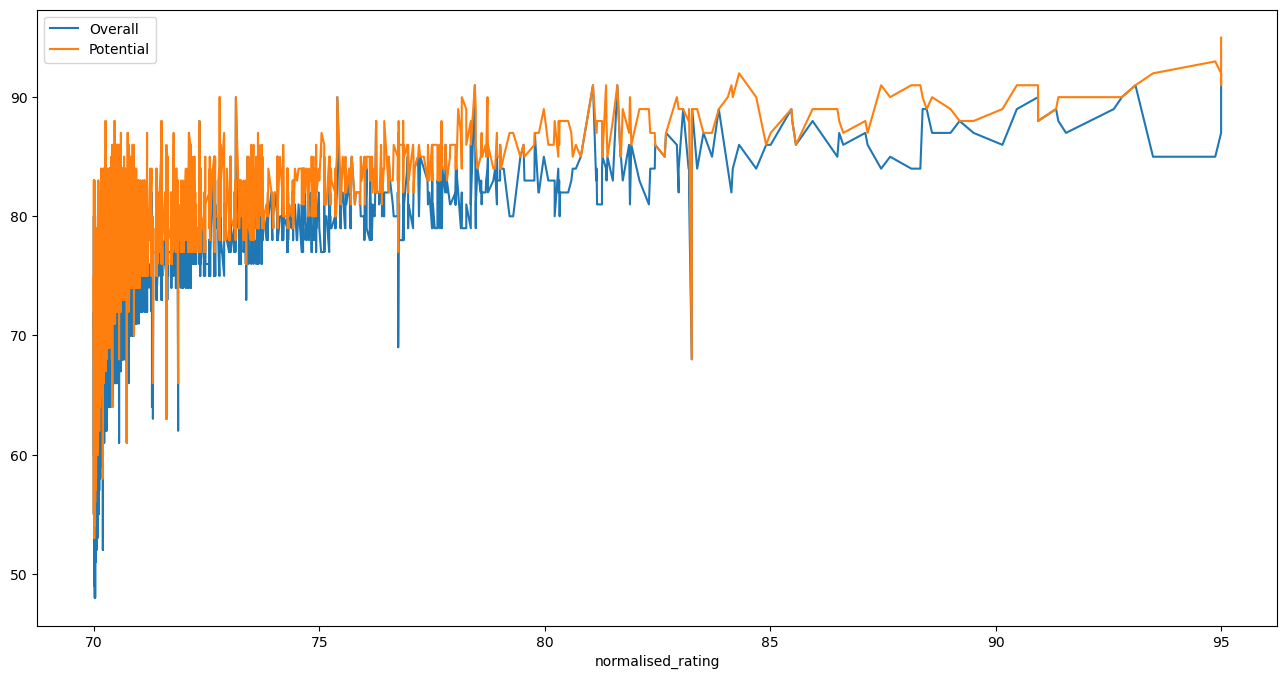

In [23]:
# Quick graph looking at the new ratings against Overall and Potential
fifa23transfermarkt2022WC = fifa23transfermarkt2022WC.sort_values(by="normalised_rating", ascending=False)

fifa23transfermarkt2022WC.plot(x="normalised_rating",y=['Overall','Potential'], kind="line")
plt.gcf().set_size_inches(16, 8)
# Show the plot
plt.show()

In [24]:
## Looking at top rated players
fifa23transfermarkt2022WC.head(10)

,Known As,Full Name,Overall,Potential,Value(in Euro),Position,Nationality,Image Link,Age,Height(in cm),...,Finishing,Short Passing,Sprint Speed,Stamina,Strength,Penalties,rank,country_full,country_abrv,normalised_rating
973,K. Mbappé,Kylian Mbappe,91,95,190500000,Attack,France,https://cdn.sofifa.net/players/231/747/23_60.png,23,182,...,93,85,97,87,76,80,4,France,FRA,95.00
3891,Rúben Dias,Ruben Santos Gato Alves Dias,88,91,107500000,Defender,Portugal,https://cdn.sofifa.net/players/239/818/23_60.png,25,187,...,29,82,67,83,89,45,9,Portugal,POR,95.00
4283,F. de Jong,Frenkie de Jong,87,92,116500000,Midfield,Netherlands,https://cdn.sofifa.net/players/228/702/23_60.png,25,180,...,72,91,83,89,74,53,8,Netherlands,NED,95.00
7817,Pedri,Pedro Gonzalez Lopez,85,93,116000000,Midfield,Spain,https://cdn.sofifa.net/players/251/854/23_60.png,19,174,...,68,87,76,88,70,53,7,Spain,ESP,94.87
4719,P. Foden,Phil Foden,85,92,109500000,Midfield,England,https://cdn.sofifa.net/players/237/692/23_60.png,22,171,...,79,85,78,83,47,64,5,England,ENG,93.49
2354,K. De Bruyne,Kevin De Bruyne,91,91,107500000,Midfield,Belgium,https://cdn.sofifa.net/players/192/985/23_60.png,31,181,...,85,93,73,88,74,83,2,Belgium,BEL,93.10
4282,V. van Dijk,Virgil van Dijk,90,90,98000000,Defender,Netherlands,https://cdn.sofifa.net/players/203/376/23_60.png,30,193,...,52,79,91,74,93,62,8,Netherlands,NED,92.80
2681,J. Kimmich,Joshua Kimmich,89,90,105500000,Midfield,Germany,https://cdn.sofifa.net/players/212/622/23_60.png,27,177,...,68,87,60,94,68,44,11,Germany,GER,92.62
4715,T. Alexander-Arnold,Trent Alexander-Arnold,87,90,100500000,Midfield,England,https://cdn.sofifa.net/players/231/281/23_60.png,23,180,...,62,87,76,89,66,55,5,England,ENG,91.56
6408,Marquinhos,Marcos Aoas Correa,88,90,92000000,Defender,Brazil,https://cdn.sofifa.net/players/207/865/23_60.png,28,183,...,59,84,81,82,78,52,1,Brazil,BRA,91.39


# Simulating the 2022 World Cup

## Preparing custom function for teams to play against eachother

#### Splitting every country into their own DataFrame

In [25]:
## Removing Spaces From Country Names
fifa23transfermarkt2022WC["Clean Nationality"]= fifa23transfermarkt2022WC["Nationality"].str.replace(r"\s+", "",regex=True)

In [26]:
unique_countries = fifa23transfermarkt2022WC['Clean Nationality'].unique()
unique_positions = fifa23transfermarkt2022WC['Position'].unique()

In [27]:
print(unique_countries)
print(unique_positions)

['France' 'Portugal' 'Netherlands' 'Spain' 'England' 'Belgium' 'Germany'
 'Brazil' 'Senegal' 'Serbia' 'Argentina' 'Uruguay' 'KoreaRepublic'
 'Canada' 'Croatia' 'Morocco' 'Poland' 'UnitedStates' 'Switzerland'
 'Denmark' 'Cameroon' 'Ghana' 'Mexico' 'Ecuador' 'Japan' 'Tunisia' 'Wales'
 'Iran' 'CostaRica' 'Australia' 'SaudiArabia' 'Qatar']
['Attack' 'Defender' 'Midfield']


In [28]:
# creating a dicttionary of each team split into seperate dataframes
WorldCupTeams = {}


# Split the DataFrame into multiple DataFrames based on the unique values

for con in unique_countries:
  for pos in unique_positions:
    df = fifa23transfermarkt2022WC[(fifa23transfermarkt2022WC['Clean Nationality'] == con) & (fifa23transfermarkt2022WC['Position'] == pos)]
    ## 28 Man Squad
    df = df.sort_values('normalised_rating', ascending=False).head(9)
    WorldCupTeams[(con, pos)] = df

#sets a dataframe for each variation of country and each position

for join, value in WorldCupTeams.items():
  # Create a DataFrame with the same name as the key
  globals()["_".join(join)] = pd.DataFrame(value)

In [29]:
def play_game(team1_def_rating,team1_mid_rating,team1_att_rating,team2_def_rating,team2_mid_rating,team2_att_rating):


  team1_rounds = 0
  team2_rounds = 0

  # Check if team 1's attack is greater than team 2's defense
  if (team1_att_rating["normalised_rating"].mean() > team2_def_rating["normalised_rating"].mean()):
    # Calculate the difference in ratings
    rating_diff = team1_att_rating["normalised_rating"].mean() - team2_def_rating["normalised_rating"].mean()
    # Calculate the probability of a normal distribution with a mean equal to the difference in ratings and a standard deviation of 1 (could be changed later for stronger/random results)
    probability = norm.cdf(rating_diff, 1)
    # Generate a random number between 0 and 1
    rand = random.random()
    # If the random number is less than the probability of winning, team 1 wins a round
    if rand < probability:
      team1_rounds += 1

    ### Debugging
    #print(round(team1_att_rating["normalised_rating"].mean(),2) , "Team1 Attack") 
    #print(round(team1_mid_rating["normalised_rating"].mean(),2) , "Team1 Midfield")
    #print(round(team1_def_rating["normalised_rating"].mean(),2) , "Team1 Defending")
    #print(round(team2_def_rating["normalised_rating"].mean(),2) , "Team2 Defending")
    #print(round(team2_mid_rating["normalised_rating"].mean(),2) , "Team2 Midfield") 
    #print(round(team2_att_rating["normalised_rating"].mean(),2) , "Team2 Attacking") 
    
  # Check if team 2's attack is greater than team 1's defense
  if (team2_att_rating["normalised_rating"].mean() > team1_def_rating["normalised_rating"].mean()):
    # Calculate the difference in ratings
    rating_diff = team2_att_rating["normalised_rating"].mean() - team1_def_rating["normalised_rating"].mean()
    probability = norm.cdf(rating_diff, 1)
    rand = random.random()
    if rand < probability:
      team2_rounds += 1
    
 

   # Check if team 2's midfield is greater than team 1's midfield
  if (team2_mid_rating["normalised_rating"].mean() > team1_mid_rating["normalised_rating"].mean()):
    rating_diff = team2_mid_rating["normalised_rating"].mean() - team1_mid_rating["normalised_rating"].mean()
    probability = norm.cdf(rating_diff, 1)
    rand = random.random()
    # If the random number is less than the probability of winning, team 2 wins a round
    if rand < probability:
      team2_rounds += 1
    
    ### Debugging
    #print(round(team1_att_rating["normalised_rating"].mean(),2) , "Team1 Attack") 
    #print(round(team1_mid_rating["normalised_rating"].mean(),2) , "Team1 Midfield")
    #print(round(team1_def_rating["normalised_rating"].mean(),2) , "Team1 Defending")
    #print(round(team2_def_rating["normalised_rating"].mean(),2) , "Team2 Defending")
    #print(round(team2_mid_rating["normalised_rating"].mean(),2) , "Team2 Midfield") 
    #print(round(team2_att_rating["normalised_rating"].mean(),2) , "Team2 Attacking") 
   
    

  if team1_rounds > team2_rounds:
    #Adding Form to a team, if they win their normalised_rating goes up by 1, down 1 for a loss and the same for a draw
    
    # Add 1 to the normalised_rating of every player in team 1
    team1_def_rating["normalised_rating"] += 1
    team1_mid_rating["normalised_rating"] += 1
    team1_att_rating["normalised_rating"] += 1
    
    # Subtract 1 from the normalised_rating of every player in team 2
    team2_def_rating["normalised_rating"] -= 1
    team2_mid_rating["normalised_rating"] -= 1
    team2_att_rating["normalised_rating"] -= 1
    return "Team 1 wins!"
  elif team1_rounds < team2_rounds:
    
    # Add 1 to the normalised_rating of every player in team 2
    team2_def_rating["normalised_rating"] += 1
    team2_mid_rating["normalised_rating"] += 1
    team2_att_rating["normalised_rating"] += 1
    
    # Subtract 1 from the normalised_rating of every player in team 1
    team1_def_rating["normalised_rating"] -= 1
    team1_mid_rating["normalised_rating"] -= 1
    team1_att_rating["normalised_rating"] -= 1
    return "Team 2 wins!"
  else:
    return "It's a draw!"

# Group Stages

#### **Note as np.random is used in the play_game function sometimes results will differ.**

## Group A
### Qatar, Ecuador, Senegal, The Netherlands

In [30]:
print(play_game(Qatar_Defender,Qatar_Midfield,Qatar_Attack,Ecuador_Defender,Ecuador_Midfield,Ecuador_Attack))
print(play_game(Qatar_Defender,Qatar_Midfield,Qatar_Attack,Senegal_Defender,Senegal_Midfield,Senegal_Attack))
print(play_game(Qatar_Defender,Qatar_Midfield,Qatar_Attack,Netherlands_Defender,Netherlands_Midfield,Netherlands_Attack))
print(play_game(Senegal_Defender,Senegal_Midfield,Senegal_Attack,Netherlands_Defender,Netherlands_Midfield,Netherlands_Attack))
print(play_game(Senegal_Defender,Senegal_Midfield,Senegal_Attack,Ecuador_Defender,Ecuador_Midfield,Ecuador_Attack))
print(play_game(Netherlands_Defender,Netherlands_Midfield,Netherlands_Attack,Ecuador_Defender,Ecuador_Midfield,Ecuador_Attack)) 
print('All games played')

Team 2 wins!
Team 2 wins!
Team 2 wins!
Team 2 wins!
It's a draw!
Team 1 wins!
All games played


## Group B
### England, Iran, USA, Wales

In [31]:
print(play_game(Iran_Defender,Iran_Midfield,Iran_Attack,Wales_Defender,Wales_Midfield,Wales_Attack))
print(play_game(Iran_Defender,Iran_Midfield,Iran_Attack,England_Defender,England_Midfield,England_Attack))
print(play_game(Iran_Defender,Iran_Midfield,Iran_Attack,UnitedStates_Defender,UnitedStates_Midfield,UnitedStates_Attack))
print(play_game(England_Defender,England_Midfield,England_Attack,UnitedStates_Defender,UnitedStates_Midfield,UnitedStates_Attack))
print(play_game(England_Defender,England_Midfield,England_Attack,Wales_Defender,Wales_Midfield,Wales_Attack))
print(play_game(UnitedStates_Defender,UnitedStates_Midfield,UnitedStates_Attack,Wales_Defender,Wales_Midfield,Wales_Attack)) 
print('All games played')

Team 2 wins!
Team 2 wins!
Team 2 wins!
Team 1 wins!
Team 1 wins!
It's a draw!
All games played


## Group C
### Argentina, Saudi Arabia, Mexico, Poland

In [32]:
print(play_game(SaudiArabia_Defender,SaudiArabia_Midfield,SaudiArabia_Attack,Argentina_Defender,Argentina_Midfield,Argentina_Attack))
print(play_game(SaudiArabia_Defender,SaudiArabia_Midfield,SaudiArabia_Attack,Mexico_Defender,Mexico_Midfield,Mexico_Attack))
print(play_game(SaudiArabia_Defender,SaudiArabia_Midfield,SaudiArabia_Attack,UnitedStates_Defender,UnitedStates_Midfield,UnitedStates_Attack))
print(play_game(Mexico_Defender,Mexico_Midfield,Mexico_Attack,UnitedStates_Defender,UnitedStates_Midfield,UnitedStates_Attack))
print(play_game(Mexico_Defender,Mexico_Midfield,Mexico_Attack,Argentina_Defender,Argentina_Midfield,Argentina_Attack))
print(play_game(UnitedStates_Defender,UnitedStates_Midfield,UnitedStates_Attack,Argentina_Defender,Argentina_Midfield,Argentina_Attack)) 
print('All games played')

Team 2 wins!
Team 2 wins!
Team 2 wins!
Team 2 wins!
Team 2 wins!
Team 2 wins!
All games played


## Group D
### France, Austrialia, Denmark, Tunisa

In [33]:
print(play_game(France_Defender,France_Midfield,France_Attack,Australia_Defender,Australia_Midfield,Australia_Attack))
print(play_game(France_Defender,France_Midfield,France_Attack,Denmark_Defender,Denmark_Midfield,Denmark_Attack))
print(play_game(France_Defender,France_Midfield,France_Attack,Tunisia_Defender,Tunisia_Midfield,Tunisia_Attack))
print(play_game(Denmark_Defender,Denmark_Midfield,Denmark_Attack,Tunisia_Defender,Tunisia_Midfield,Tunisia_Attack))
print(play_game(Denmark_Defender,Denmark_Midfield,Denmark_Attack,Australia_Defender,Australia_Midfield,Australia_Attack))
print(play_game(Tunisia_Defender,Tunisia_Midfield,Tunisia_Attack,Australia_Defender,Australia_Midfield,Australia_Attack)) 
print('All games played')

Team 1 wins!
Team 1 wins!
Team 1 wins!
Team 1 wins!
Team 1 wins!
It's a draw!
All games played


## Group E
### Spain, Costa Rica, Germany, Japan

In [34]:
print(play_game(Spain_Defender,Spain_Midfield,Spain_Attack,CostaRica_Defender,CostaRica_Midfield,CostaRica_Attack)) 
print(play_game(Spain_Defender,Spain_Midfield,Spain_Attack,Japan_Defender,Japan_Midfield,Japan_Attack)) 
print(play_game(Spain_Defender,Spain_Midfield,Spain_Attack,Germany_Defender,Germany_Midfield,Germany_Attack)) 
print(play_game(Japan_Defender,Japan_Midfield,Japan_Attack,Germany_Defender,Germany_Midfield,Germany_Attack)) 
print(play_game(Japan_Defender,Japan_Midfield,Japan_Attack,CostaRica_Defender,CostaRica_Midfield,CostaRica_Attack)) 
print(play_game(Germany_Defender,Germany_Midfield,Germany_Attack,CostaRica_Defender,CostaRica_Midfield,CostaRica_Attack))  
print('All games played') 

Team 1 wins!
Team 1 wins!
It's a draw!
Team 2 wins!
It's a draw!
Team 1 wins!
All games played


## Group F
### Belgium, Canada, Morocco, Croatia

In [35]:
print(play_game(Canada_Defender,Canada_Midfield,Canada_Attack,Morocco_Defender,Morocco_Midfield,Morocco_Attack)) 
print(play_game(Canada_Defender,Canada_Midfield,Canada_Attack,Croatia_Defender,Croatia_Midfield,Croatia_Attack)) 
print(play_game(Canada_Defender,Canada_Midfield,Canada_Attack,Belgium_Defender,Belgium_Midfield,Belgium_Attack)) 
print(play_game(Croatia_Defender,Croatia_Midfield,Croatia_Attack,Belgium_Defender,Belgium_Midfield,Belgium_Attack)) 
print(play_game(Croatia_Defender,Croatia_Midfield,Croatia_Attack,Morocco_Defender,Morocco_Midfield,Morocco_Attack)) 
print(play_game(Belgium_Defender,Belgium_Midfield,Belgium_Attack,Morocco_Defender,Morocco_Midfield,Morocco_Attack))  
print('All games played') 

It's a draw!
Team 2 wins!
Team 2 wins!
It's a draw!
It's a draw!
It's a draw!
All games played


## Group G
### Brazil, Serbia, Switzerland, Cameroon

In [36]:
print(play_game(Brazil_Defender,Brazil_Midfield,Brazil_Attack,Cameroon_Defender,Cameroon_Midfield,Cameroon_Attack)) 
print(play_game(Brazil_Defender,Brazil_Midfield,Brazil_Attack,Switzerland_Defender,Switzerland_Midfield,Switzerland_Attack)) 
print(play_game(Brazil_Defender,Brazil_Midfield,Brazil_Attack,Serbia_Defender,Serbia_Midfield,Serbia_Attack)) 
print(play_game(Switzerland_Defender,Switzerland_Midfield,Switzerland_Attack,Serbia_Defender,Serbia_Midfield,Serbia_Attack)) 
print(play_game(Switzerland_Defender,Switzerland_Midfield,Switzerland_Attack,Cameroon_Defender,Cameroon_Midfield,Cameroon_Attack)) 
print(play_game(Serbia_Defender,Serbia_Midfield,Serbia_Attack,Cameroon_Defender,Cameroon_Midfield,Cameroon_Attack))  
print('All games played') 

Team 1 wins!
Team 1 wins!
Team 1 wins!
Team 2 wins!
It's a draw!
It's a draw!
All games played


## Group H
### Portugal, Ghana, Uruguay, Korea Republic

In [37]:
print(play_game(Portugal_Defender,Portugal_Midfield,Portugal_Attack,Ghana_Defender,Ghana_Midfield,Ghana_Attack)) 
print(play_game(Portugal_Defender,Portugal_Midfield,Portugal_Attack,KoreaRepublic_Defender,KoreaRepublic_Midfield,KoreaRepublic_Attack)) 
print(play_game(Portugal_Defender,Portugal_Midfield,Portugal_Attack,Uruguay_Defender,Uruguay_Midfield,Uruguay_Attack)) 
print(play_game(KoreaRepublic_Defender,KoreaRepublic_Midfield,KoreaRepublic_Attack,Uruguay_Defender,Uruguay_Midfield,Uruguay_Attack)) 
print(play_game(KoreaRepublic_Defender,KoreaRepublic_Midfield,KoreaRepublic_Attack,Ghana_Defender,Ghana_Midfield,Ghana_Attack)) 
print(play_game(Uruguay_Defender,Uruguay_Midfield,Uruguay_Attack,Ghana_Defender,Ghana_Midfield,Ghana_Attack))  
print('All games played') 

Team 1 wins!
Team 1 wins!
Team 1 wins!
Team 2 wins!
Team 2 wins!
It's a draw!
All games played


## Final Results Group Results

#### Group A
Netherlands 
Ecuador 
 
#### Group B
England 
Usa 
 
#### Group C
Argentina 
Mexico 

#### Group D
France 
Australia 

#### Group E
Spain 
Germany 
 
#### Group F
Belgium 
Croatia 
 
#### Group G
Brazil 
Serbia 
 
#### Group H
Portugal 
Uruguay 

# Round of 16 (First plays second in next group (ie: 1st in A against 2nd in B) and so on)
#### Netherlands vs USA
#### England vs Ecuador
#### Argentina vs Australia
#### France vs Mexico
#### Spain vs Croatia
#### Belgium vs Germany
#### Brazil vs Uruguay
#### Portugal vs Serbia

In [38]:
#creating a seperate knockout match function , with this there has to be a winner
def play_knockout_game(team1_def_rating,team1_mid_rating,team1_att_rating,team2_def_rating,team2_mid_rating,team2_att_rating):


  team1_rounds = 0
  team2_rounds = 0

  # Check if team 1's attack is greater than team 2's defense
  if (team1_att_rating["normalised_rating"].mean() > team2_def_rating["normalised_rating"].mean()):
    rating_diff = team1_att_rating["normalised_rating"].mean() - team2_def_rating["normalised_rating"].mean()
    probability = norm.cdf(rating_diff, 1)
    rand = random.random()
    if rand < probability:
      team1_rounds += 1
    
  # Check if team 2's attack is greater than team 1's defense
  if (team2_att_rating["normalised_rating"].mean() > team1_def_rating["normalised_rating"].mean()):
    rating_diff = team2_att_rating["normalised_rating"].mean() - team1_def_rating["normalised_rating"].mean()
    probability = norm.cdf(rating_diff, 1)
    rand = random.random()
    if rand < probability:
      team2_rounds += 1
    
 

   # Check if team 2's midfield is greater than team 1's midfield
  if (team2_mid_rating["normalised_rating"].mean() > team1_mid_rating["normalised_rating"].mean()):
    rating_diff = team2_mid_rating["normalised_rating"].mean() - team1_mid_rating["normalised_rating"].mean()
    probability = norm.cdf(rating_diff, 1)
    rand = random.random()
    if rand < probability:
      team2_rounds += 1

    
  if team1_rounds > team2_rounds:
    #Adding Form to a team, if they win their normalised_rating goes up by 1, down 1 for a loss and the same for a draw
    
    # Add 1 to the normalised_rating of every player in team 1
    team1_def_rating["normalised_rating"] += 1
    team1_mid_rating["normalised_rating"] += 1
    team1_att_rating["normalised_rating"] += 1
    
    # Subtract 1 from the normalised_rating of every player in team 2
    team2_def_rating["normalised_rating"] -= 1
    team2_mid_rating["normalised_rating"] -= 1
    team2_att_rating["normalised_rating"] -= 1
    return "Team 1 wins!"
  elif team1_rounds < team2_rounds:
    
    # Add 1 to the normalised_rating of every player in team 2
    team2_def_rating["normalised_rating"] += 1
    team2_mid_rating["normalised_rating"] += 1
    team2_att_rating["normalised_rating"] += 1
    
    # Subtract 1 from the normalised_rating of every player in team 1
    team1_def_rating["normalised_rating"] -= 1
    team1_mid_rating["normalised_rating"] -= 1
    team1_att_rating["normalised_rating"] -= 1
    return "Team 2 wins!"
  else:
        ## New code so a winner must occur
    return random.choice(["Tean 1", "Team 2"]) +" won in penalties!"

In [39]:
print(play_knockout_game(Netherlands_Defender,Netherlands_Midfield,Netherlands_Attack,UnitedStates_Defender,UnitedStates_Midfield,UnitedStates_Attack)) 

print(play_knockout_game(England_Defender,England_Midfield,England_Attack,Ecuador_Defender,Ecuador_Midfield,Ecuador_Attack)) 

print(play_knockout_game(Argentina_Defender,Argentina_Midfield,Argentina_Attack,Australia_Defender,Australia_Midfield,Australia_Attack)) 

print(play_knockout_game(France_Defender,France_Midfield,France_Attack,Mexico_Defender,Mexico_Midfield,Mexico_Attack)) 

print(play_knockout_game(Spain_Defender,Spain_Midfield,Spain_Attack,Croatia_Defender,Croatia_Midfield,Croatia_Attack)) 

print(play_knockout_game(Belgium_Defender,Belgium_Midfield,Belgium_Attack,Germany_Defender,Germany_Midfield,Germany_Attack)) 

print(play_knockout_game(Brazil_Defender,Brazil_Midfield,Brazil_Attack,Uruguay_Defender,Uruguay_Midfield,Uruguay_Attack)) 

print(play_knockout_game(Portugal_Defender,Portugal_Midfield,Portugal_Attack,Serbia_Defender,Serbia_Midfield,Serbia_Attack))  

Team 1 wins!
Team 1 wins!
Team 1 wins!
Team 1 wins!
Team 1 wins!
Team 2 wins!
Team 1 wins!
Team 1 wins!


# Quarter Finals
#### Spain vs Brazil
#### England vs France
#### Argentina vs USA
#### Gemrany vs Portugal

In [40]:
print(play_knockout_game(Spain_Defender,Spain_Midfield,Spain_Attack,Brazil_Defender,Brazil_Midfield,Brazil_Attack)) 

print(play_knockout_game(England_Defender,England_Midfield,England_Attack,France_Defender,France_Midfield,France_Attack)) 

print(play_knockout_game(Argentina_Defender,Argentina_Midfield,Argentina_Attack,UnitedStates_Defender,UnitedStates_Midfield,UnitedStates_Attack)) 

print(play_knockout_game(Germany_Defender,Germany_Midfield,Germany_Attack,Portugal_Defender,Portugal_Midfield,Portugal_Attack)) 

Team 2 won in penalties!
Team 2 won in penalties!
Team 1 wins!
Tean 1 won in penalties!


# Semi Finals
#### France vs Portugal
#### Argentina vs Brazil

In [41]:
print(play_knockout_game(France_Defender,France_Midfield,France_Attack,Portugal_Defender,Portugal_Midfield,Portugal_Attack)) 

print(play_knockout_game(Argentina_Defender,Argentina_Midfield,Argentina_Attack,Brazil_Defender,Brazil_Midfield,Brazil_Attack)) 


Team 2 won in penalties!
Team 2 wins!


# World Cup Final
#### Brazil vs Portugal

In [42]:
print(play_knockout_game(Brazil_Defender,Brazil_Midfield,Brazil_Attack,Portugal_Defender,Portugal_Midfield,Portugal_Attack)) 

Team 2 won in penalties!


# Third Place
#### France vs Argentina


In [43]:
print(play_knockout_game(France_Defender,France_Midfield,France_Attack,Argentina_Defender,Argentina_Midfield,Argentina_Attack)) 

Tean 1 won in penalties!


#### Argentina wins in penalties

# World Cup Winners: **Brazil**

In [44]:
Brazil_XI= pd.concat([Brazil_Defender.head(4), Brazil_Midfield.head(4), Brazil_Attack.head(3)], ignore_index=True, sort=False)

In [45]:
Brazil_XI

,Known As,Full Name,Overall,Potential,Value(in Euro),Position,Nationality,Image Link,Age,Height(in cm),...,Short Passing,Sprint Speed,Stamina,Strength,Penalties,rank,country_full,country_abrv,normalised_rating,Clean Nationality
0,Marquinhos,Marcos Aoas Correa,88,90,92000000,Defender,Brazil,https://cdn.sofifa.net/players/207/865/23_60.png,28,183,...,84,81,82,78,52,1,Brazil,BRA,96.39,Brazil
1,Ederson,Ederson Santana de Moraes,89,91,88000000,Defender,Brazil,https://cdn.sofifa.net/players/210/257/23_60.png,28,188,...,61,63,41,78,51,1,Brazil,BRA,95.47,Brazil
2,Alisson,Alisson Ramses Becker,89,90,79000000,Defender,Brazil,https://cdn.sofifa.net/players/212/831/23_60.png,29,191,...,60,49,32,78,23,1,Brazil,BRA,93.38,Brazil
3,Éder Militão,Eder Gabriel Militao,84,89,57500000,Defender,Brazil,https://cdn.sofifa.net/players/240/130/23_60.png,24,186,...,79,88,86,79,60,1,Brazil,BRA,88.38,Brazil
4,Casemiro,Carlos Henrique Venancio Casimiro,89,89,86000000,Midfield,Brazil,https://cdn.sofifa.net/players/200/145/23_60.png,30,185,...,84,66,90,90,66,1,Brazil,BRA,93.47,Brazil
5,Fabinho,Fabio Henrique Tavares,87,88,77000000,Midfield,Brazil,https://cdn.sofifa.net/players/209/499/23_60.png,28,188,...,84,68,88,81,90,1,Brazil,BRA,91.53,Brazil
6,Rodrygo,Rodrygo Silva de Goes,81,88,52500000,Midfield,Brazil,https://cdn.sofifa.net/players/243/812/23_60.png,21,174,...,77,88,81,42,74,1,Brazil,BRA,86.27,Brazil
7,Antony,Antony Matheus dos Santos,82,88,49000000,Midfield,Brazil,https://cdn.sofifa.net/players/255/475/23_60.png,22,174,...,75,91,79,62,66,1,Brazil,BRA,85.52,Brazil
8,Vinícius Jr.,Vinicius Jose de Oliveira Junior,86,92,109000000,Attack,Brazil,https://cdn.sofifa.net/players/238/794/23_60.png,21,176,...,75,95,84,62,65,1,Brazil,BRA,89.31,Brazil
9,Neymar Jr,Neymar da Silva Santos Jr.,89,89,99500000,Attack,Brazil,https://cdn.sofifa.net/players/190/871/23_60.png,30,175,...,85,86,79,52,91,1,Brazil,BRA,88.07,Brazil


# Data Analysis

In [46]:
## Checking columns to plan Analysis
fifa23transfermarkt2022WC.columns

Index(['Known As', 'Full Name', 'Overall', 'Potential', 'Value(in Euro)',
       'Position', 'Nationality', 'Image Link', 'Age', 'Height(in cm)',
       'TotalStats', 'Club Name', 'Wage(in Euro)', 'Release Clause',
       'Club Position', 'Club Jersey Number', 'Skill Moves',
       'International Reputation', 'National Team Name',
       'National Team Image Link', 'National Team Position',
       'National Team Jersey Number', 'Finishing', 'Short Passing',
       'Sprint Speed', 'Stamina', 'Strength', 'Penalties', 'rank',
       'country_full', 'country_abrv', 'normalised_rating',
       'Clean Nationality'],
      dtype='object')

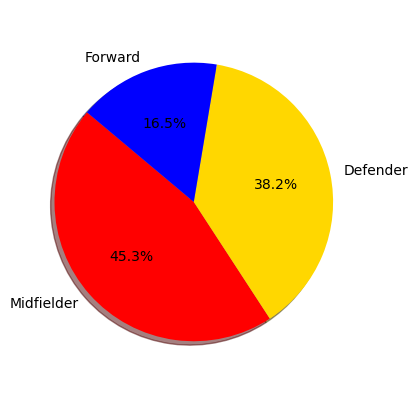

In [47]:
## Distribution of Positions
plt.figure(figsize=(4,5))

labels = 'Midfielder', 'Defender', 'Forward'
colors = ['r', 'gold','blue', 'green']

plt.pie(fifa23transfermarkt2022WC["Position"].value_counts(), labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

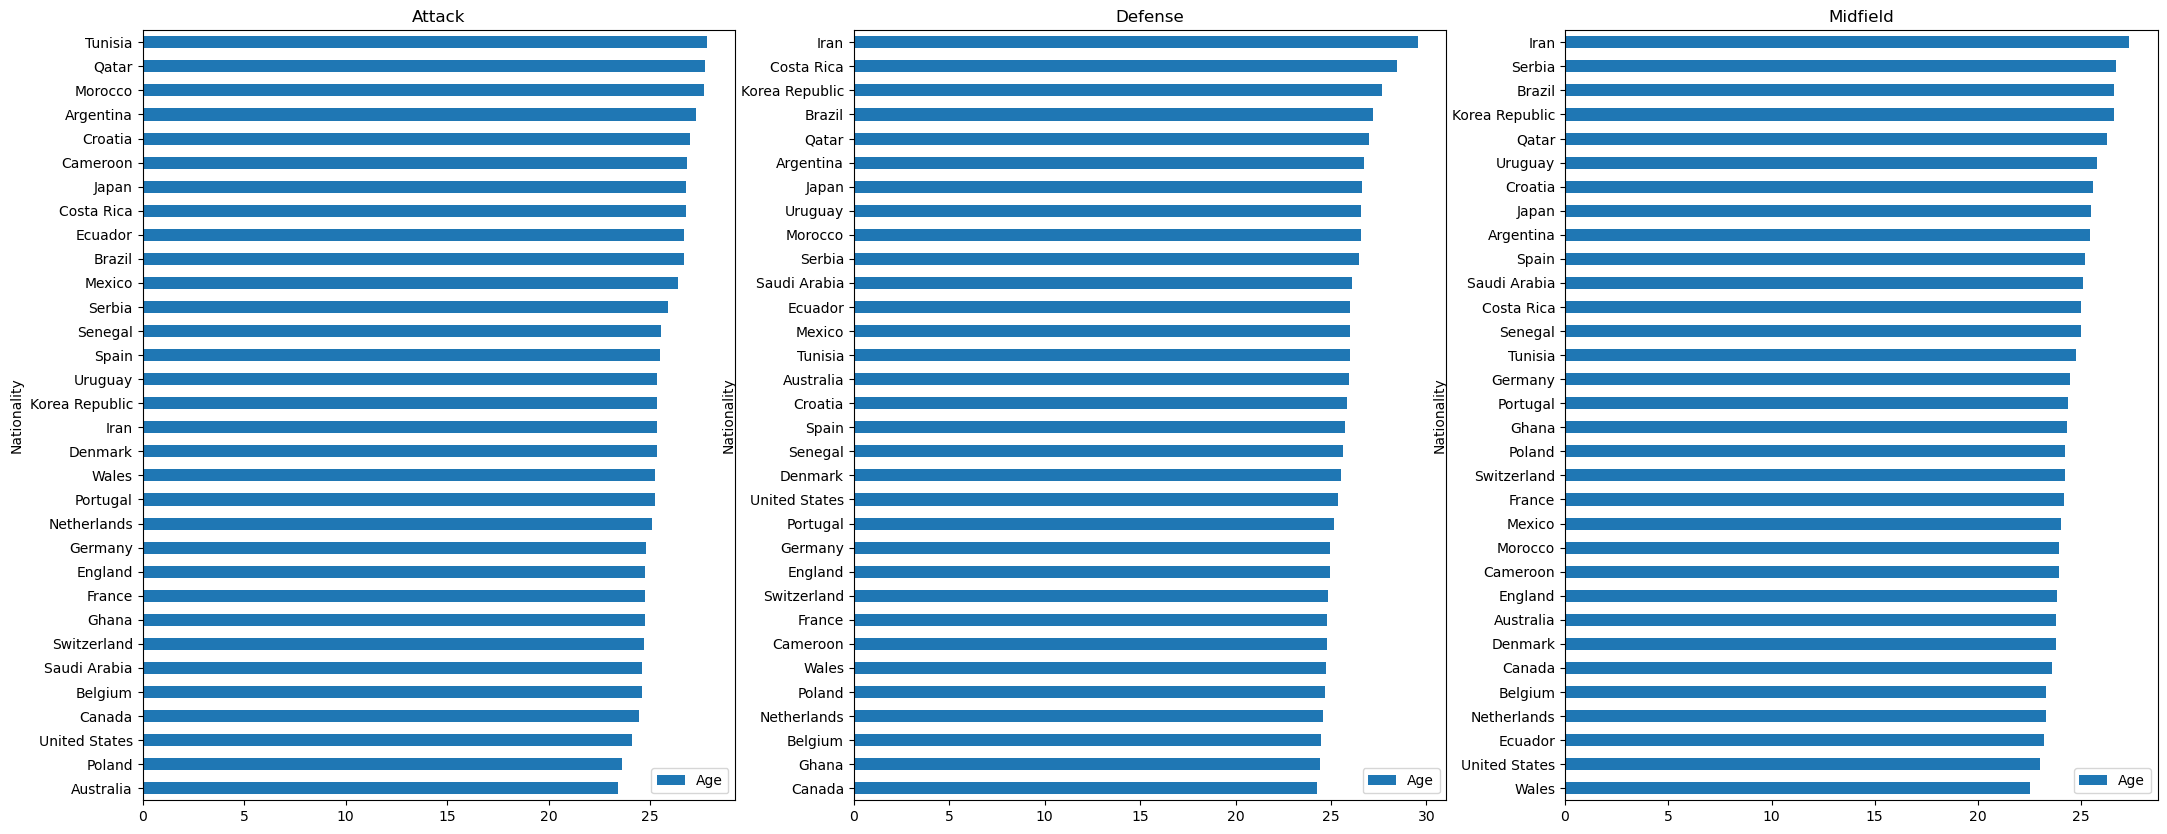

In [48]:
## Average age of each Position per country
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

attack_avg_age_by_country = Attack.groupby(['Nationality'], as_index=False)['Age'].mean().sort_values('Age',ascending=True)
defense_avg_age_by_country = Defender.groupby(['Nationality'], as_index=False)['Age'].mean().sort_values('Age',ascending=True)
midfield_avg_age_by_country = Midfield.groupby(['Nationality'], as_index=False)['Age'].mean().sort_values('Age',ascending=True)
attack_avg_age_by_country = attack_avg_age_by_country.set_index('Nationality')
midfield_avg_age_by_country = midfield_avg_age_by_country.set_index('Nationality')
defense_avg_age_by_country = defense_avg_age_by_country.set_index('Nationality')



attack_avg_age_by_country.plot(kind='barh', title='Attack', ax=ax1)
midfield_avg_age_by_country.plot(kind='barh', title='Midfield', ax=ax3)
defense_avg_age_by_country.plot(kind='barh', title='Defense', ax=ax2)

plt.gcf().set_size_inches(26, 10)
plt.show()

## Analysing Player Financial Data

In [49]:
fifa23transfermarkt2022WC.columns

Index(['Known As', 'Full Name', 'Overall', 'Potential', 'Value(in Euro)',
       'Position', 'Nationality', 'Image Link', 'Age', 'Height(in cm)',
       'TotalStats', 'Club Name', 'Wage(in Euro)', 'Release Clause',
       'Club Position', 'Club Jersey Number', 'Skill Moves',
       'International Reputation', 'National Team Name',
       'National Team Image Link', 'National Team Position',
       'National Team Jersey Number', 'Finishing', 'Short Passing',
       'Sprint Speed', 'Stamina', 'Strength', 'Penalties', 'rank',
       'country_full', 'country_abrv', 'normalised_rating',
       'Clean Nationality'],
      dtype='object')

In [50]:
Top_10_Earners = fifa23transfermarkt2022WC.sort_values('Wage(in Euro)', ascending=False).head(10)
Top_10_Earners = Top_10_Earners[['Known As', 'Full Name', 'normalised_rating','Overall', 'Potential', 'Value(in Euro)',
       'Position', 'Nationality','Age','Wage(in Euro)', 'National Team Name']]
Top_10_Earners.head(10)

,Known As,Full Name,normalised_rating,Overall,Potential,Value(in Euro),Position,Nationality,Age,Wage(in Euro),National Team Name
972,K. Benzema,Karim Benzema,78.45,91,91,64000000,Attack,France,34,450000,France
1964,R. Lewandowski,Robert Lewandowski,81.07,91,91,84000000,Attack,Poland,33,420000,Poland
2354,K. De Bruyne,Kevin De Bruyne,93.10,91,91,107500000,Midfield,Belgium,31,350000,Belgium
2683,T. Kroos,Toni Kroos,85.49,88,88,72000000,Midfield,Germany,32,310000,-
3892,Bernardo Silva,Bernardo Mota Carvalho e Silva,90.94,88,88,97500000,Midfield,Portugal,27,260000,Portugal
2355,T. Courtois,Thibaut Courtois,90.94,90,91,90000000,Defender,Belgium,30,250000,Belgium
3893,João Cancelo,Joao Pedro Cavaco Cancelo,89.20,88,88,82500000,Defender,Portugal,28,250000,Portugal
2684,A. Rüdiger,Antonio Rudiger,87.11,87,88,73500000,Defender,Germany,29,250000,Germany
6405,Casemiro,Carlos Henrique Venancio Casimiro,88.47,89,89,86000000,Midfield,Brazil,30,240000,-
4714,H. Kane,Harry Kane,83.86,89,89,105500000,Attack,England,28,240000,England


In [51]:
Top_10_Valued_Players = fifa23transfermarkt2022WC.sort_values('Value(in Euro)', ascending=False).head(10)
Top_10_Valued_Players = Top_10_Valued_Players[['Known As', 'Full Name', 'normalised_rating','Overall', 'Potential', 'Value(in Euro)',
       'Position', 'Nationality','Age','Wage(in Euro)', 'National Team Name']]
Top_10_Valued_Players.head(10)

,Known As,Full Name,normalised_rating,Overall,Potential,Value(in Euro),Position,Nationality,Age,Wage(in Euro),National Team Name
973,K. Mbappé,Kylian Mbappe,95.00,91,95,190500000,Attack,France,23,230000,France
4283,F. de Jong,Frenkie de Jong,95.00,87,92,116500000,Midfield,Netherlands,25,230000,Netherlands
7817,Pedri,Pedro Gonzalez Lopez,94.87,85,93,116000000,Midfield,Spain,19,115000,Spain
4719,P. Foden,Phil Foden,93.49,85,92,109500000,Midfield,England,22,180000,England
6411,Vinícius Jr.,Vinicius Jose de Oliveira Junior,84.31,86,92,109000000,Attack,Brazil,21,200000,-
2354,K. De Bruyne,Kevin De Bruyne,93.10,91,91,107500000,Midfield,Belgium,31,350000,Belgium
3891,Rúben Dias,Ruben Santos Gato Alves Dias,95.00,88,91,107500000,Defender,Portugal,25,230000,Portugal
2681,J. Kimmich,Joshua Kimmich,92.62,89,90,105500000,Midfield,Germany,27,130000,Germany
4714,H. Kane,Harry Kane,83.86,89,89,105500000,Attack,England,28,240000,England
7160,H. Son,Heung Min Son,83.27,89,89,101000000,Attack,Korea Republic,29,240000,-


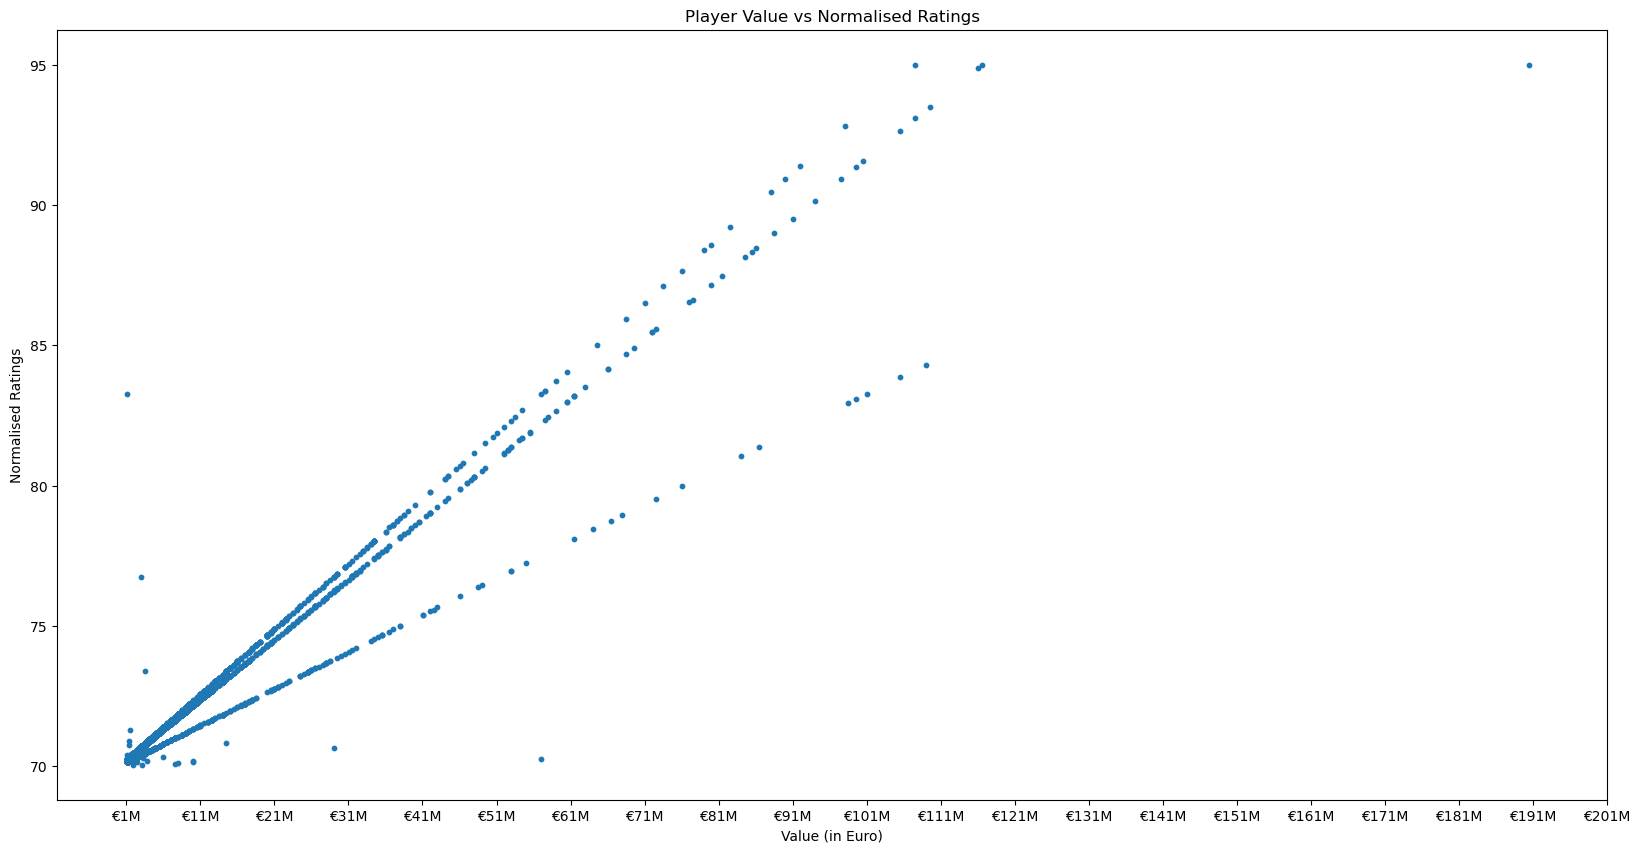

In [52]:
fifa23transfermarkt2022WC['Value(in Euro)']= fifa23transfermarkt2022WC['Value(in Euro)'].astype(int)
### dropping players worth under 10 million for a cleaner graph
PV_vs_NR = fifa23transfermarkt2022WC.loc[fifa23transfermarkt2022WC['Value(in Euro)'] > 1000000]
### creating a y axis for every 50k

ax = PV_vs_NR.plot.scatter(x='Value(in Euro)', y='normalised_rating',s=10)
ax.set_title('Player Value vs Normalised Ratings')
ax.set_xlabel('Value (in Euro)')
ax.set_ylabel('Normalised Ratings')
ax.xaxis.set_ticks(range(990000, 210000000, 10000000))
## setting to be in millions
ax.xaxis.set_ticklabels(['€{:,.0f}M'.format(x/1000000) for x in ax.xaxis.get_ticklocs()])
plt.gcf().set_size_inches(20, 10)
plt.show()

#### Strong correlation with a players value and their normalised rating
#### Note the outlier Kylian Mbappe who is the ighest valued player in the world at the minute and is said to be the next Messi/Ronaldo

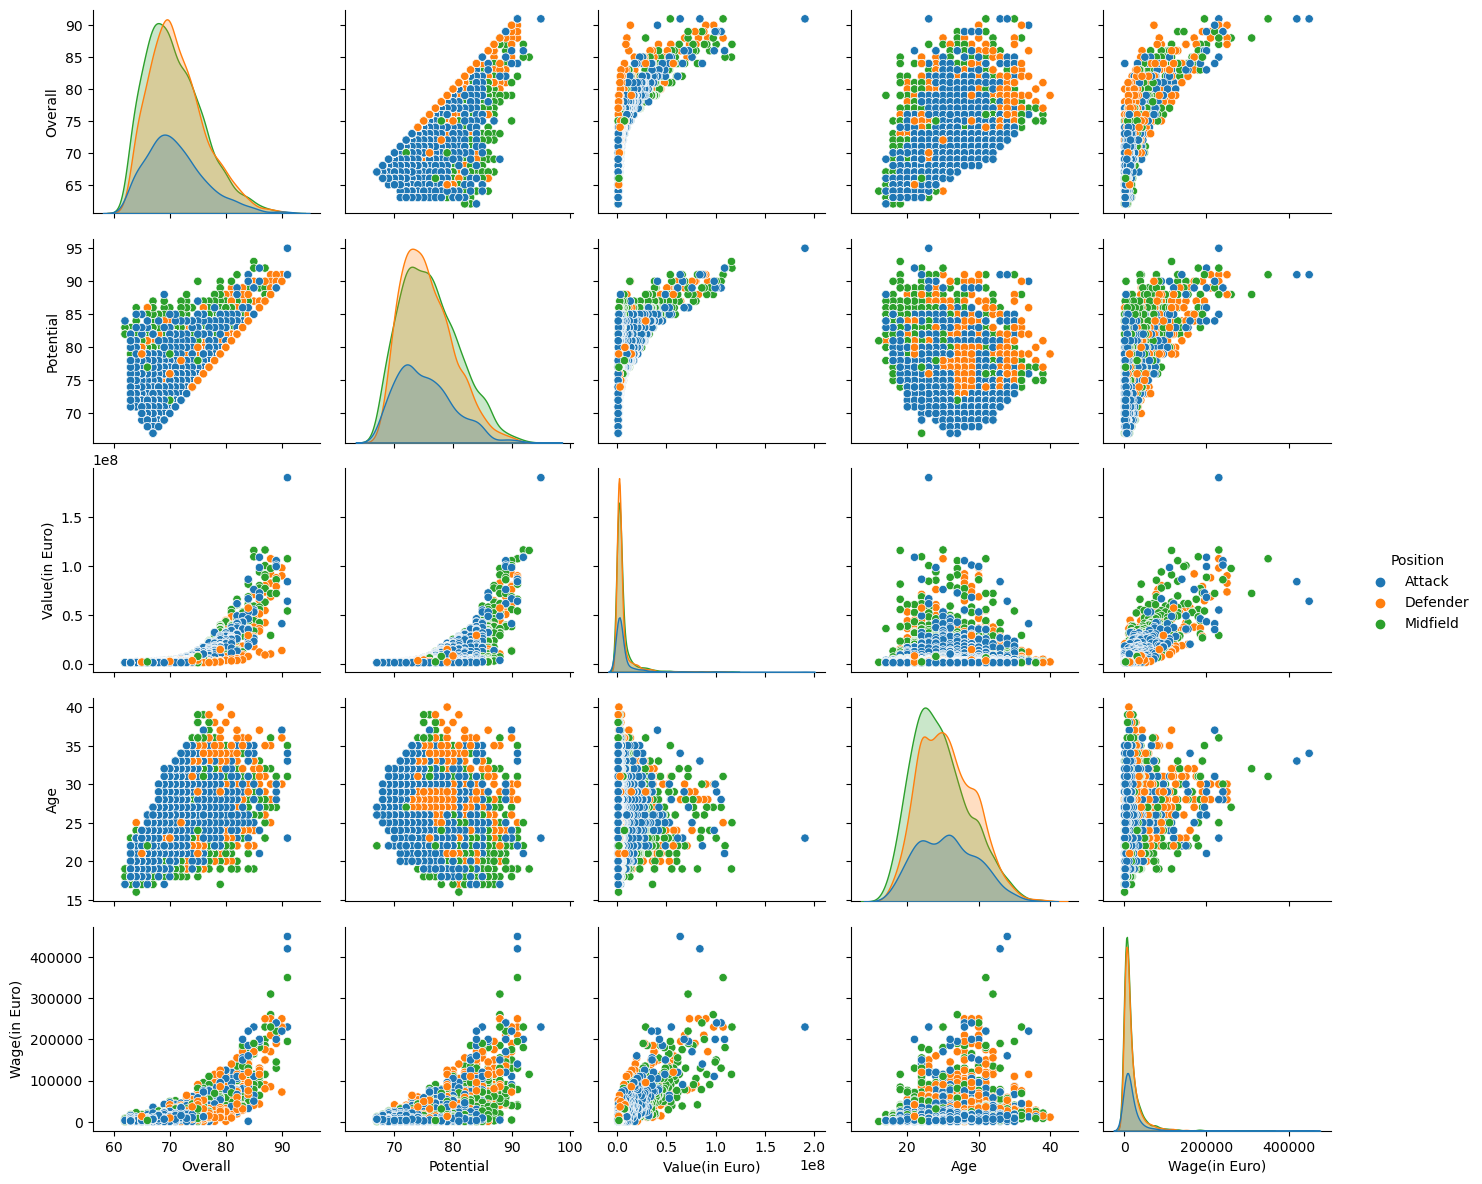

In [53]:
## Pairplot of all players split by Position
values = ['Overall', 'Potential', 'Value(in Euro)',
       'Position','Age','Wage(in Euro)']

sns.pairplot(PV_vs_NR[values],hue='Position',kind='scatter')
plt.gcf().set_size_inches(15, 12)
plt.show()

## Further Analysis

TypeError: 'Legend' object is not callable

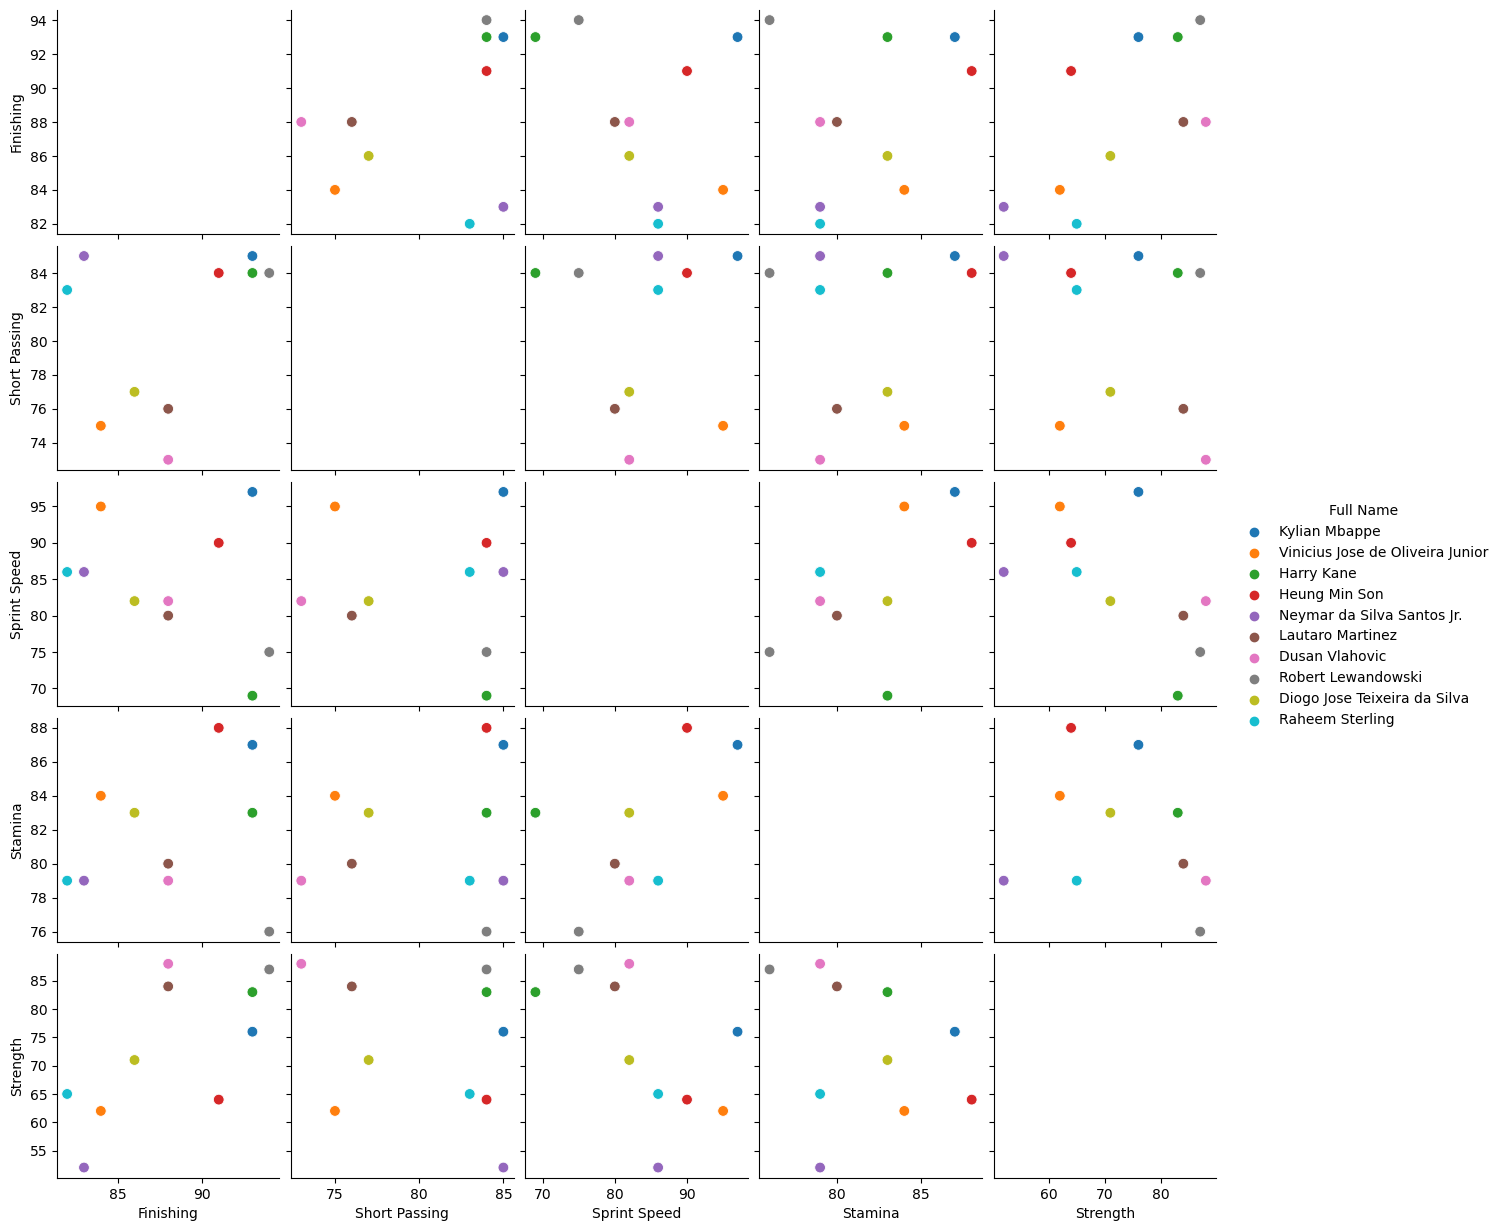

In [54]:
## Quick look at the top 10 attacking players comparing their attributes
playerstats = ['Finishing', 'Short Passing','Sprint Speed', 'Stamina', 'Strength','Full Name']
Top10Attack= Attack.sort_values(by="normalised_rating", ascending=False).head(10)

## Pair Plot
ax = sns.pairplot(Top10Attack[playerstats],hue='Full Name',plot_kws={"s": 60})
ax.legend(bbox_to_anchor=(1, 0))
ax.set_title('Pairwise plot of the top 10 attackers stats', fontsize=25)
plt.gcf().set_size_inches(10, 8)
plt.show()

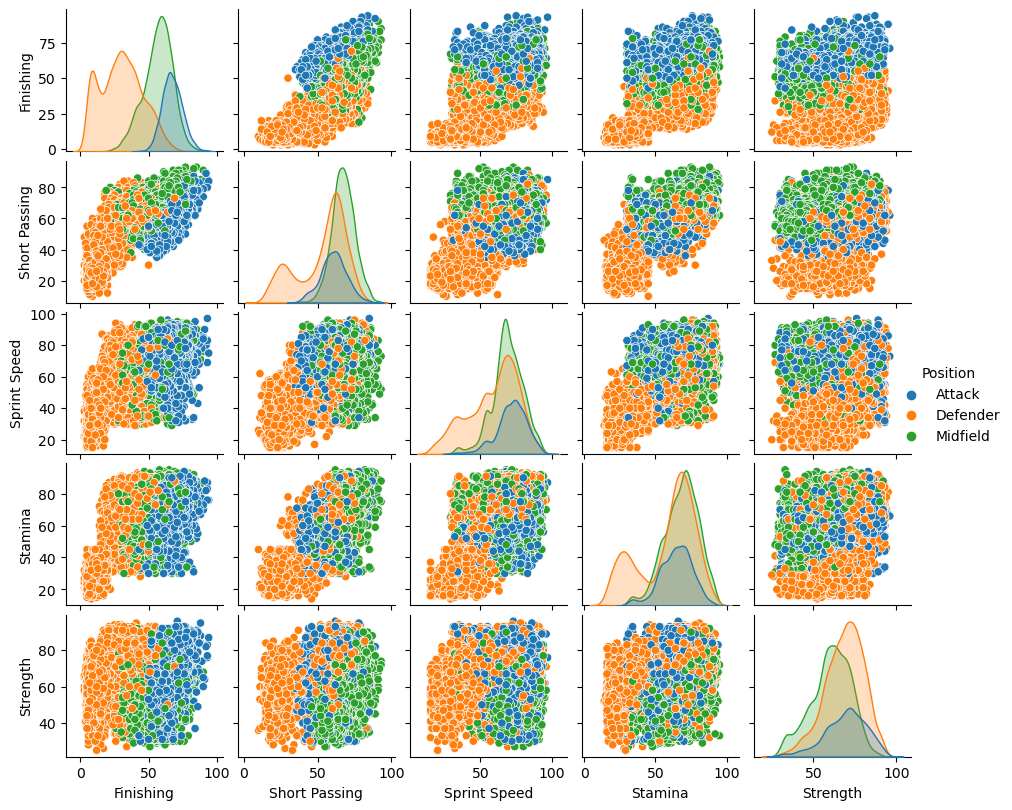

In [55]:
## Pairplot of all players split by Position
playerstats = ['Finishing', 'Short Passing','Sprint Speed', 'Stamina', 'Strength','Position']


sns.pairplot(fifa23transfermarkt2022WC[playerstats],hue='Position',kind='scatter')
plt.gcf().set_size_inches(10, 8)
plt.show()

## Top 50 Players on each country

In [56]:
# Create an empty list to store the top 50 players for each nationality
top_50_players_list = []

# Loop through each nationality and get the top 50 players
for nationality, data in fifa23transfermarkt2022WC.groupby(["Nationality"]):
  # Get the top 50 players for the current nationality
  top_50_players = data.sort_values(by="normalised_rating", ascending=False).head(50)
  
  # Add the top 50 players for the current nationality to the list
  top_50_players_list.append(top_50_players)

In [57]:
# combine them all into on df
top_50_players_by_nationality = pd.concat(top_50_players_list)
top_50_players_by_nationality = pd.concat(top_50_players_list, join='outer')
top_50_players_by_nationality = pd.DataFrame(top_50_players_by_nationality)
top_50_players_by_nationality=top_50_players_by_nationality.reset_index(drop=True)

In [58]:
## Creating an Average Player for Every Country and Position
avg_values_by_country_and_position = top_50_players_by_nationality.groupby(['Nationality'], as_index=False)[['Finishing', 'Short Passing','Sprint Speed', 'Stamina', 'Strength']].mean()
avg_values_by_country_and_position['Average Stats']=avg_values_by_country_and_position.sum(axis=1, numeric_only=True)
## Dividing by the no of stats
avg_values_by_country_and_position['Average Stats']=avg_values_by_country_and_position['Average Stats']/5

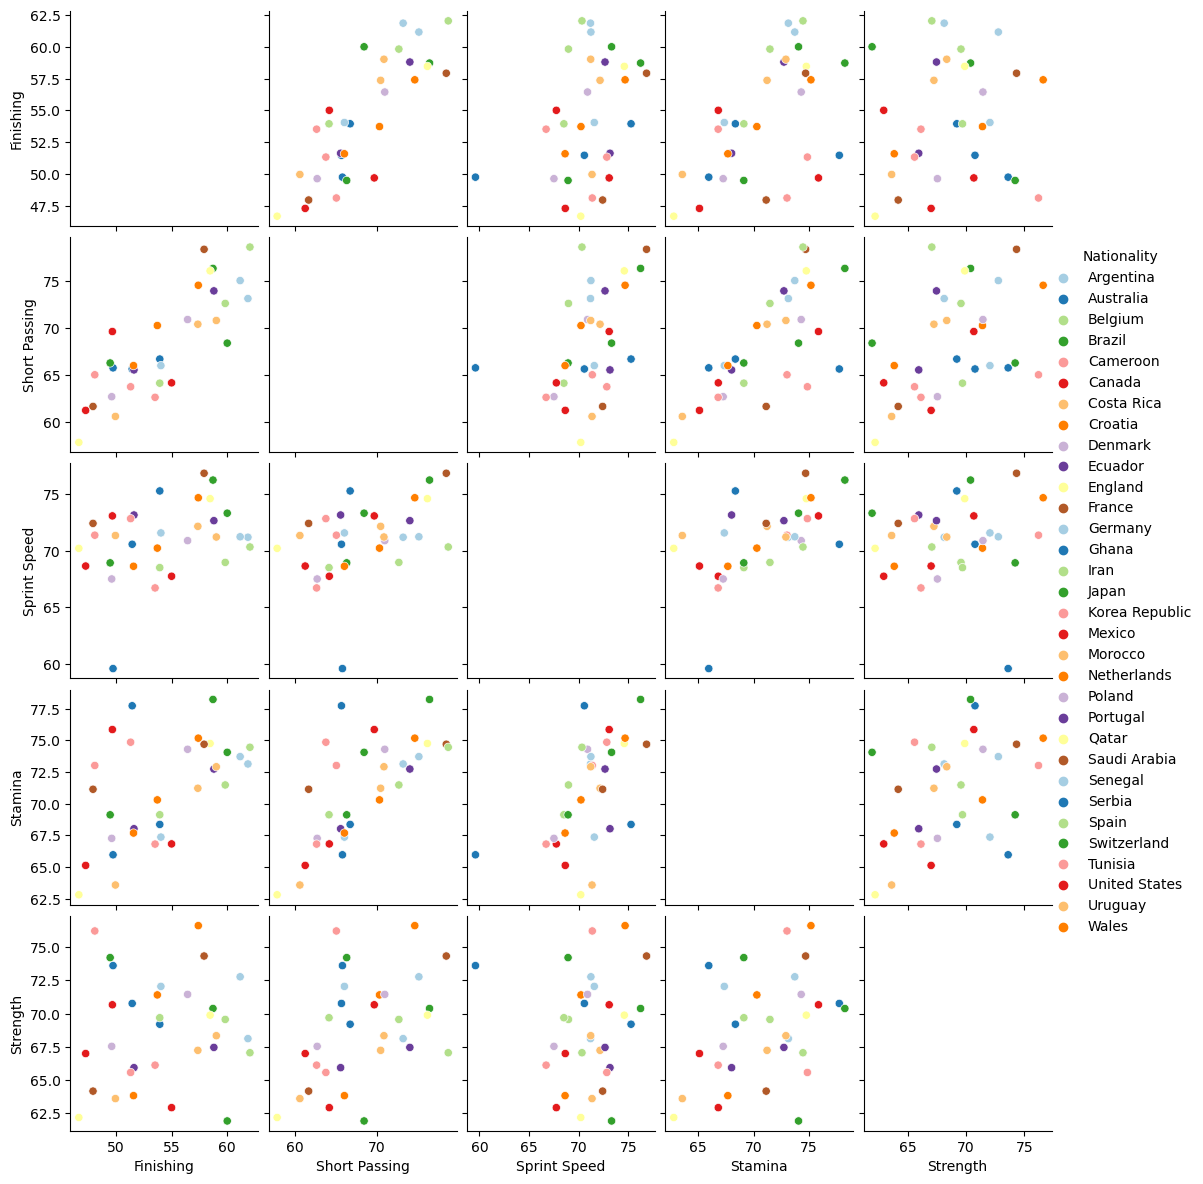

In [59]:
## Average Team Player pairplot
playerstats = ['Finishing', 'Short Passing','Sprint Speed', 'Stamina', 'Strength','Nationality']

palette = sns.color_palette("Paired", 32)
g=sns.pairplot(avg_values_by_country_and_position[playerstats],hue='Nationality',kind='scatter',palette=palette)

plt.gcf().set_size_inches(12, 12)
plt.show()

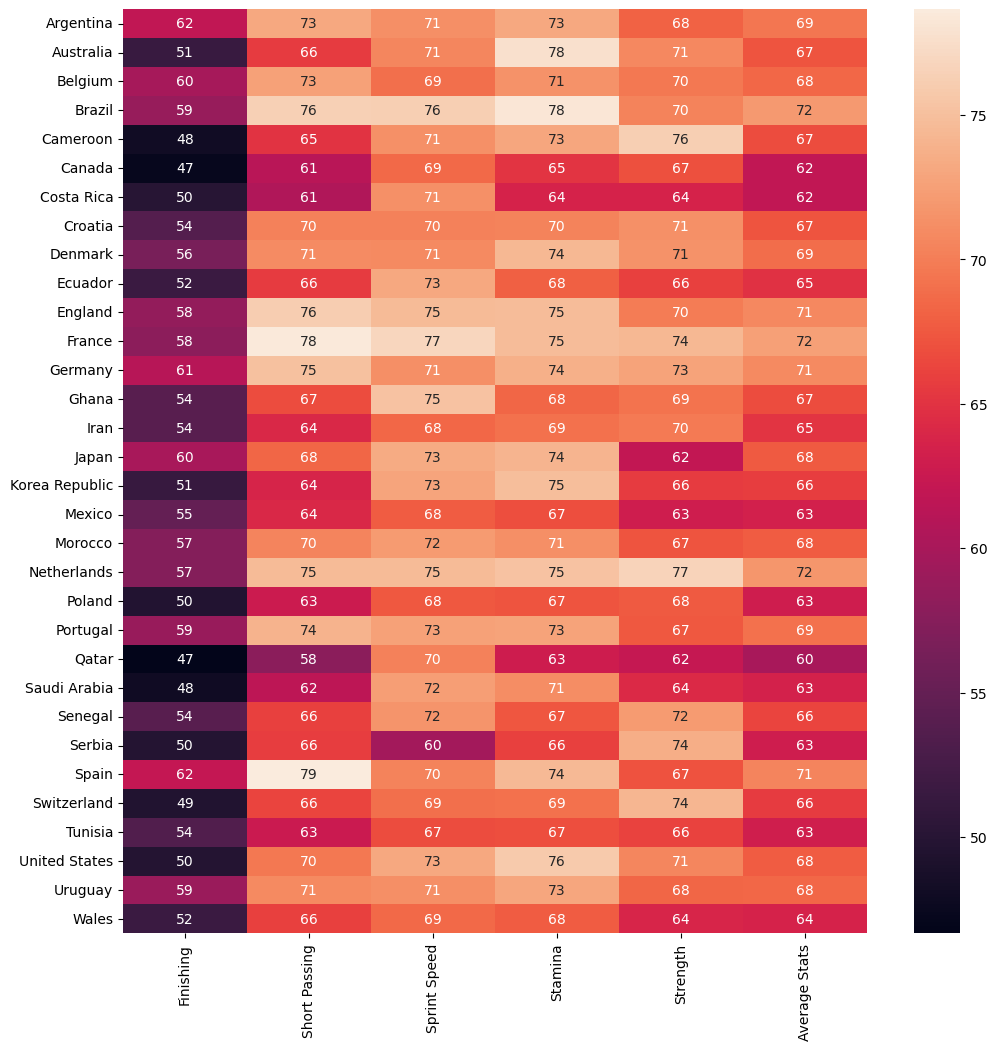

In [61]:
## Heatmap to see where countries perform the best/worst
playerstats = ['Finishing', 'Short Passing','Sprint Speed', 'Stamina', 'Strength','Average Stats']

yticklabels = avg_values_by_country_and_position['Nationality']
sns.heatmap(avg_values_by_country_and_position[playerstats],yticklabels=yticklabels,annot=True)
plt.gcf().set_size_inches(12, 12)
plt.show()

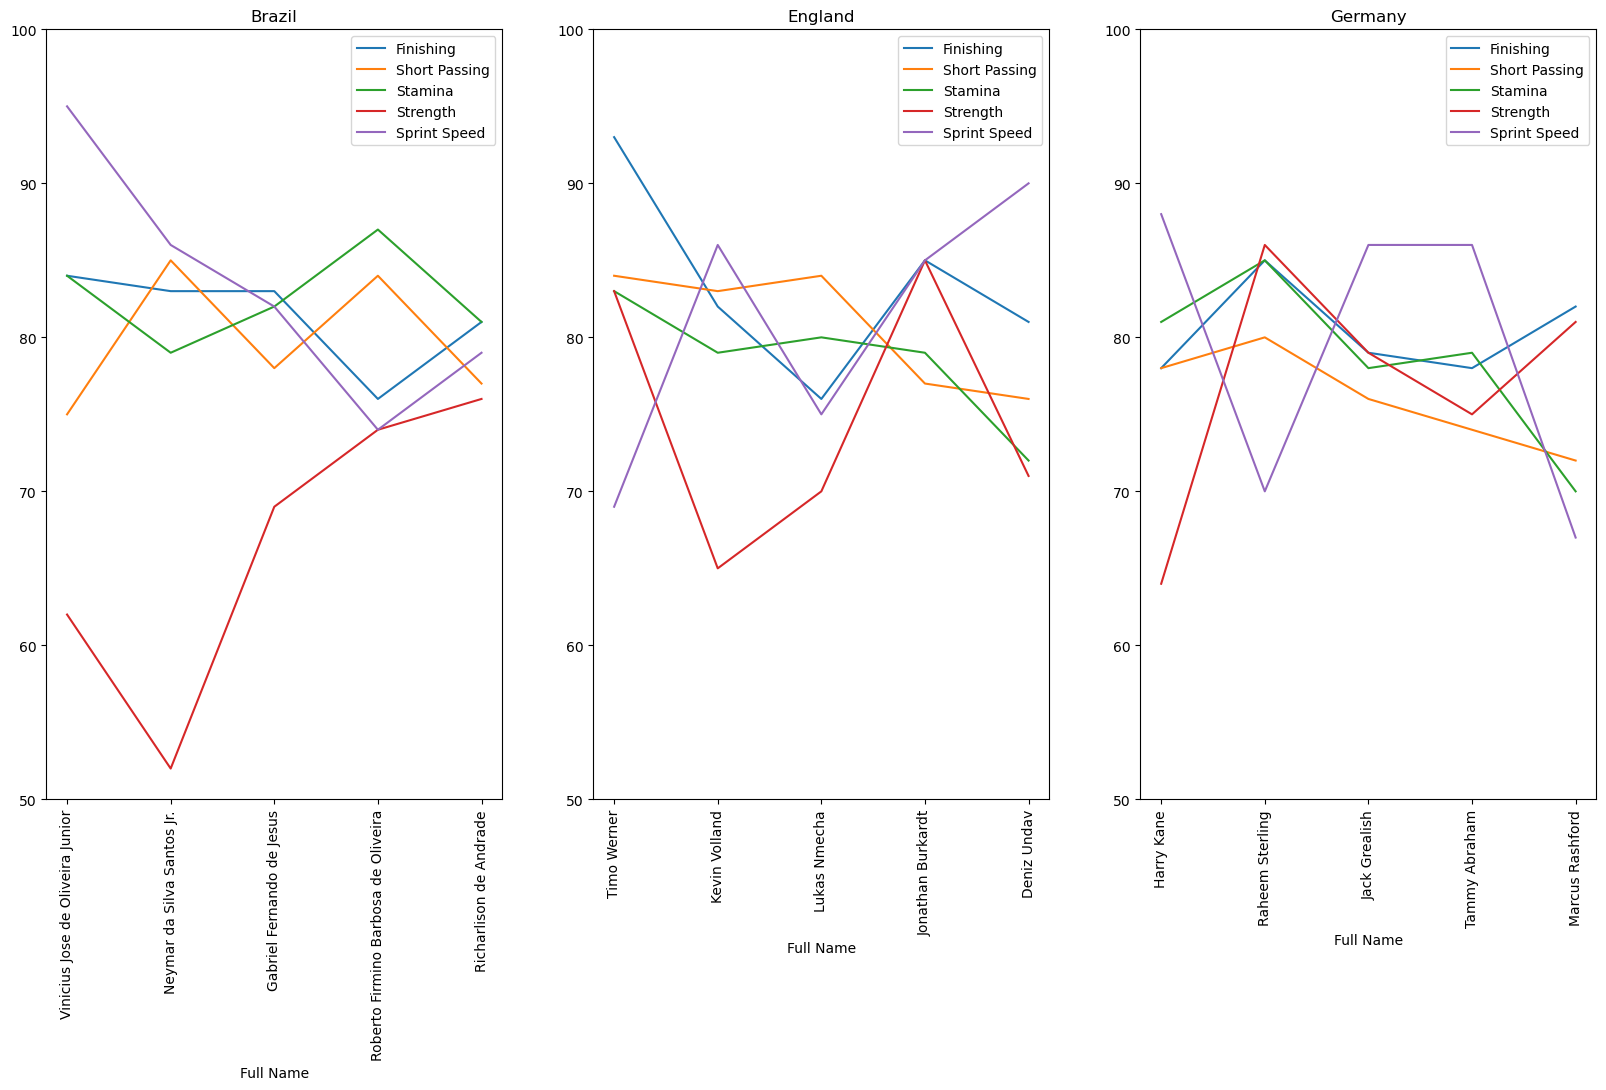

In [62]:
## Comparing three top clubs Attackers for their top 5 players acros sthe three stats
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

Brazil_Attack = Brazil_Attack.sort_values(by="normalised_rating", ascending=False)
Germany_Attack = Germany_Attack.sort_values(by="normalised_rating", ascending=False)
England_Attack = England_Attack.sort_values(by="normalised_rating", ascending=False)

names1 = Brazil_Attack['Full Name'].head(5)
names2 = Germany_Attack['Full Name'].head(5)
names3 = England_Attack['Full Name'].head(5)

Brazil_Attack.head(5).plot(x='Full Name',y=['Finishing','Short Passing','Stamina','Strength','Sprint Speed'],kind='line', title='Brazil', ax=ax1)
England_Attack.head(5).plot(x='Full Name',y=['Finishing','Short Passing','Stamina','Strength','Sprint Speed'],kind='line', title='England', ax=ax2)
Germany_Attack.head(5).plot(x='Full Name',y=['Finishing','Short Passing','Stamina','Strength','Sprint Speed'],kind='line', title='Germany', ax=ax3)

ax1.set_ylim(50, 100)
ax2.set_ylim(50, 100)
ax3.set_ylim(50, 100)
ax1.set_xticks(range(len(names1)))
ax1.set_xticklabels(names1, rotation=90)
ax2.set_xticks(range(len(names2)))
ax2.set_xticklabels(names2, rotation=90)
ax3.set_xticks(range(len(names3)))
ax3.set_xticklabels(names3, rotation=90)

plt.gcf().set_size_inches(20, 10)
           
plt.show()

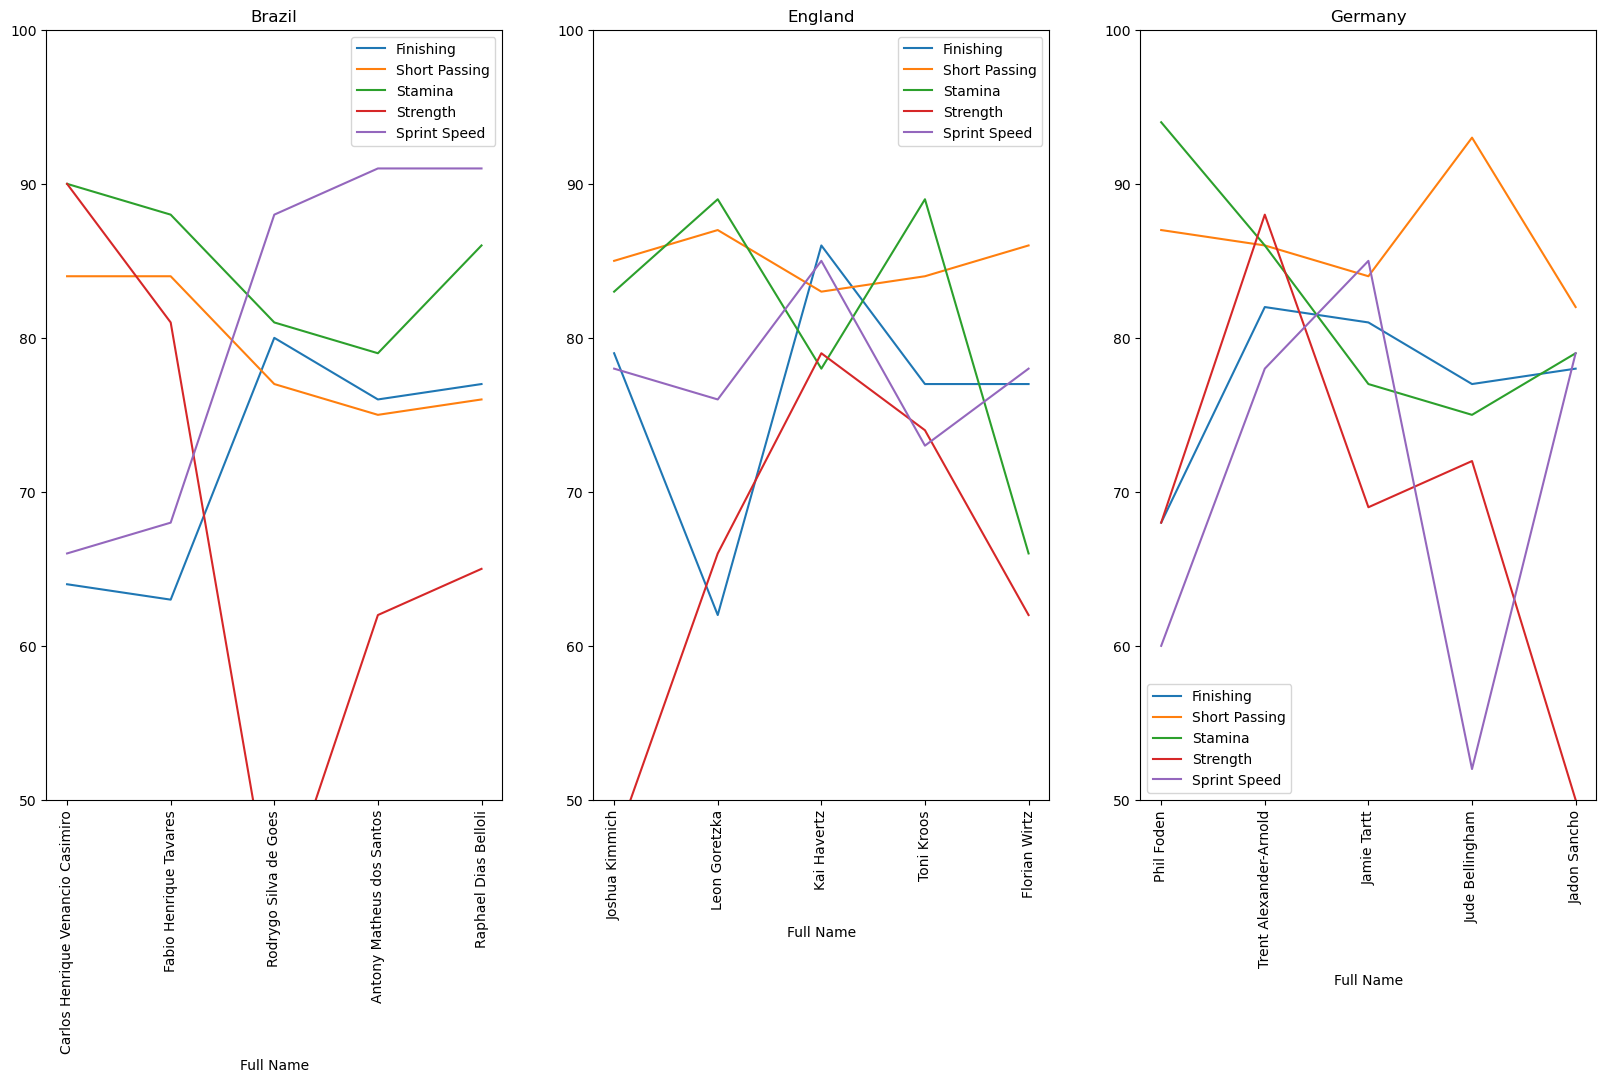

In [63]:
## Comparing three top clubs Midfielders for their top 5 players acros sthe three stats
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

Brazil_Midfield = Brazil_Midfield.sort_values(by="normalised_rating", ascending=False)
Germany_Midfield = Germany_Midfield.sort_values(by="normalised_rating", ascending=False)
England_Midfield = England_Midfield.sort_values(by="normalised_rating", ascending=False)

names1 = Brazil_Midfield['Full Name'].head(5)
names2 = Germany_Midfield['Full Name'].head(5)
names3 = England_Midfield['Full Name'].head(5)

Brazil_Midfield.head(5).plot(x='Full Name',y=['Finishing','Short Passing','Stamina','Strength','Sprint Speed'],kind='line', title='Brazil', ax=ax1)
England_Midfield.head(5).plot(x='Full Name',y=['Finishing','Short Passing','Stamina','Strength','Sprint Speed'],kind='line', title='England', ax=ax2)
Germany_Midfield.head(5).plot(x='Full Name',y=['Finishing','Short Passing','Stamina','Strength','Sprint Speed'],kind='line', title='Germany', ax=ax3)


ax1.set_ylim(50, 100)
ax2.set_ylim(50, 100)
ax3.set_ylim(50, 100)
ax1.set_xticks(range(len(names1)))
ax1.set_xticklabels(names1, rotation=90)
ax2.set_xticks(range(len(names2)))
ax2.set_xticklabels(names2, rotation=90)
ax3.set_xticks(range(len(names3)))
ax3.set_xticklabels(names3, rotation=90)

plt.gcf().set_size_inches(20, 10)
           
plt.show()

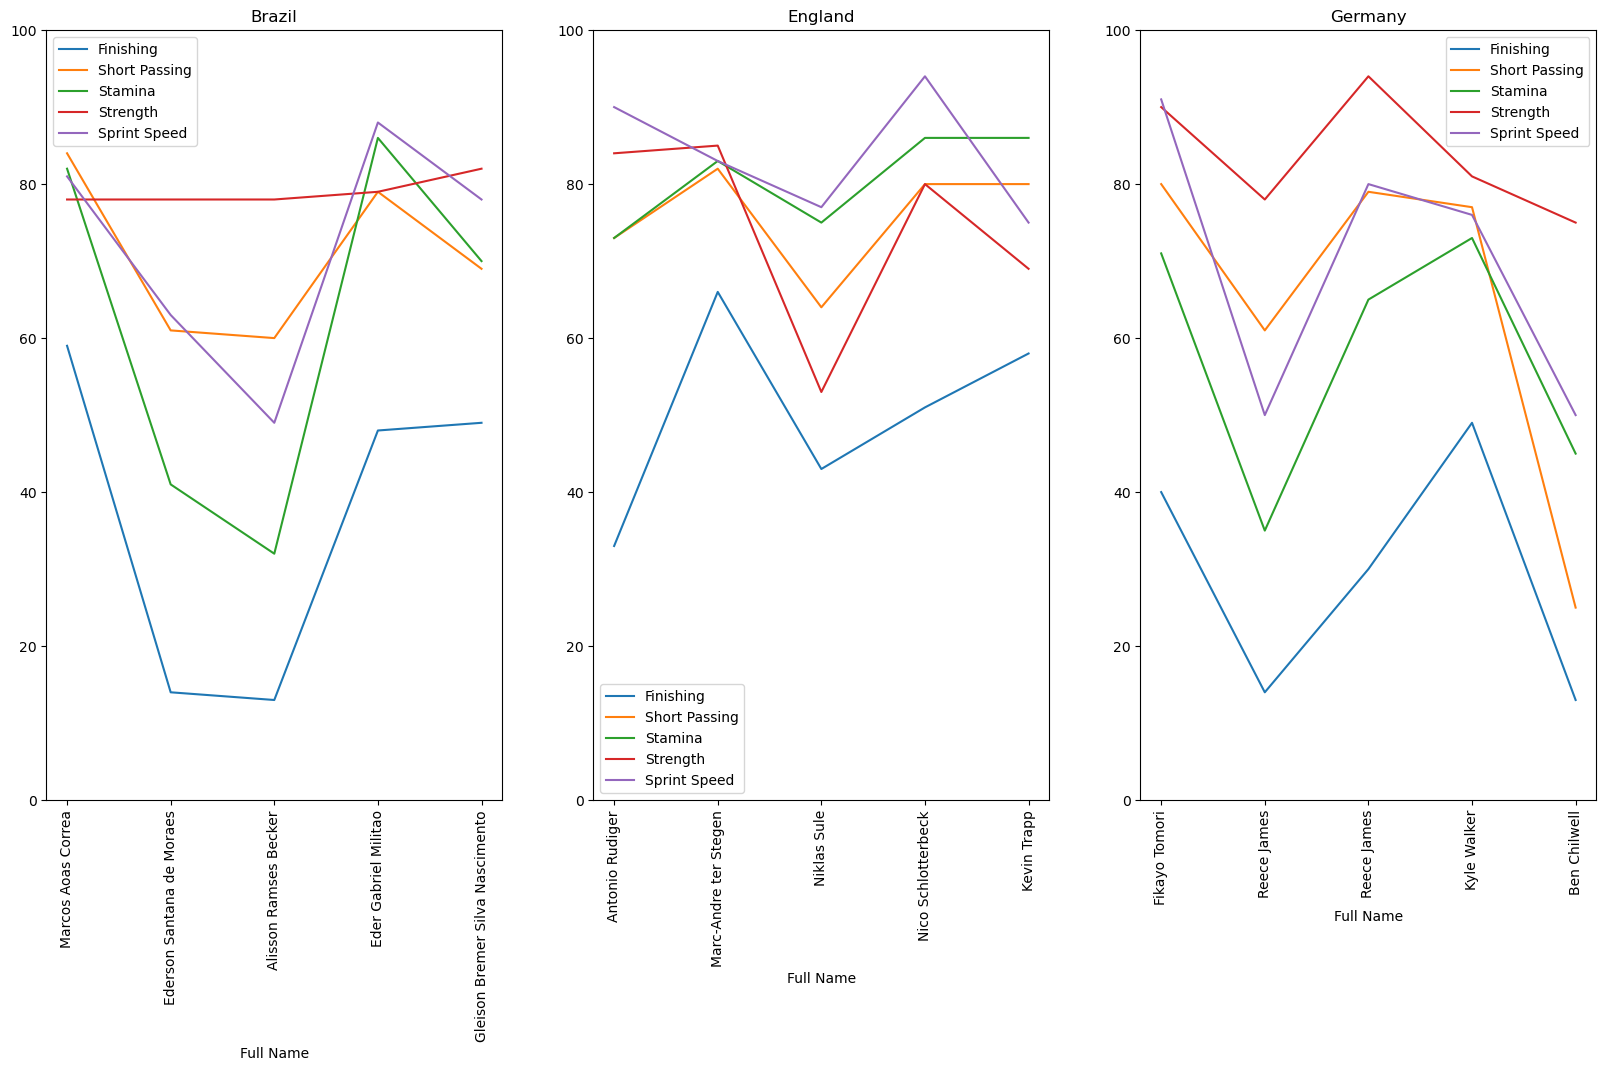

In [64]:
## Comparing three top clubs Defenders for their top 5 players acros sthe three stats
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

Brazil_Defender = Brazil_Defender.sort_values(by="normalised_rating", ascending=False)
Germany_Defender = Germany_Defender.sort_values(by="normalised_rating", ascending=False)
England_Defender = England_Defender.sort_values(by="normalised_rating", ascending=False)

names1 = Brazil_Defender['Full Name'].head(5)
names2 = Germany_Defender['Full Name'].head(5)
names3 = England_Defender['Full Name'].head(5)

Brazil_Defender.head(5).plot(x='Full Name',y=['Finishing','Short Passing','Stamina','Strength','Sprint Speed'],kind='line', title='Brazil', ax=ax1)
England_Defender.head(5).plot(x='Full Name',y=['Finishing','Short Passing','Stamina','Strength','Sprint Speed'],kind='line', title='England', ax=ax2)
Germany_Defender.head(5).plot(x='Full Name',y=['Finishing','Short Passing','Stamina','Strength','Sprint Speed'],kind='line', title='Germany', ax=ax3)


ax1.set_ylim(0, 100)
ax2.set_ylim(0, 100)
ax3.set_ylim(0, 100)
ax1.set_xticks(range(len(names1)))
ax1.set_xticklabels(names1, rotation=90)
ax2.set_xticks(range(len(names2)))
ax2.set_xticklabels(names2, rotation=90)
ax3.set_xticks(range(len(names3)))
ax3.set_xticklabels(names3, rotation=90)

plt.gcf().set_size_inches(20, 10)
           
plt.show()

## Team Rankings After World Cup
#### Effected by the form of the team during the World Cup Simulation

In [65]:
## Re-ranking by only teams in the World Cup (worst team is rank 32 etc)
fifarankings = fifarankings[fifarankings["country_full"].isin(WC_2022_teams)].sort_values('rank',ascending=True)
fifarankings['rank'] = fifarankings['rank'].rank(ascending=True)
fifarankings['rank'] = fifarankings['rank'].astype(int)

In [66]:
# new ranks
fifarankings.tail(5)

,rank,country_full,country_abrv
63826,28,Cameroon,CMR
63827,29,Ecuador,ECU
63860,30,Qatar,QAT
63861,31,Saudi Arabia,KSA
63898,32,Ghana,GHA


In [67]:
## Creating a new rank with my normalised ratings
team_ranks = fifa23transfermarkt2022WC.groupby(['Nationality'], as_index=False)['normalised_rating'].mean()
team_ranks = team_ranks.sort_values('normalised_rating',ascending=False)
team_ranks.index = np.arange(1, len(team_ranks) + 1)

In [68]:
team_ranks['Team Ranking'] = team_ranks['normalised_rating'].rank(ascending=False)
team_ranks['Team Ranking'] = team_ranks['Team Ranking'].astype(int)

In [69]:
## Joining them back together
Change_in_team_rankings = pd.merge(team_ranks, fifarankings, left_on='Nationality', right_on='country_full')
Change_in_team_rankings['Difference'] =  Change_in_team_rankings['rank'] - Change_in_team_rankings['Team Ranking']

In [70]:
Change_in_team_rankings.sort_values('Difference',ascending=False)

,Nationality,normalised_rating,Team Ranking,rank,country_full,country_abrv,Difference
2,Serbia,71.101068,3,19,Serbia,SRB,16
11,Cameroon,70.696351,12,28,Cameroon,CMR,16
17,Ghana,70.556028,18,32,Ghana,GHA,14
7,Morocco,70.885243,8,20,Morocco,MAR,12
12,Japan,70.692911,13,21,Japan,JPN,8
0,Portugal,71.275809,1,8,Portugal,POR,7
5,Croatia,70.966848,6,11,Croatia,CRO,5
21,Canada,70.456341,22,27,Canada,CAN,5
10,Senegal,70.780075,11,16,Senegal,SEN,5
24,Ecuador,70.334972,25,29,Ecuador,ECU,4


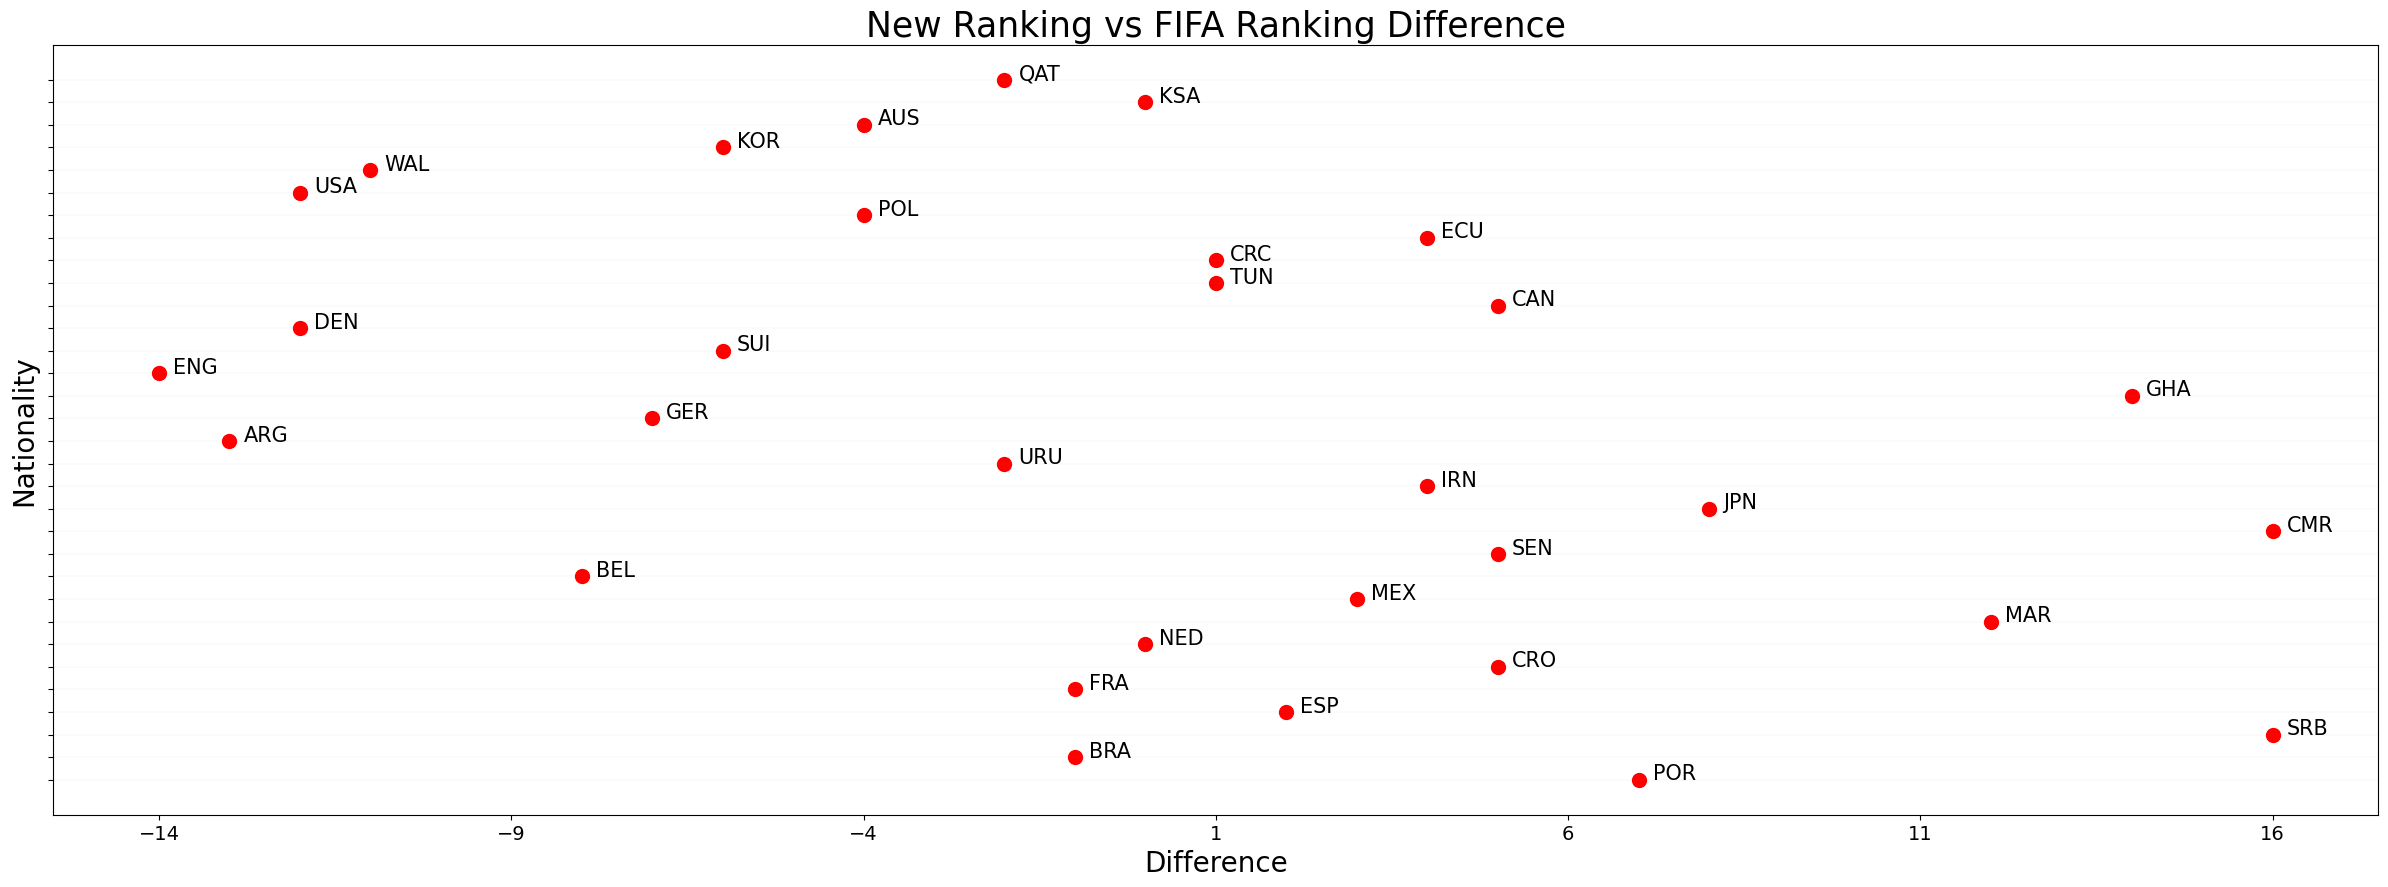

In [71]:
## Plotting the teams that have improved the most compare the old and the new ranks by looking at their differences
ax = Change_in_team_rankings.plot(x='Difference', y='Nationality', kind='scatter', color='red',s=100)
x = Change_in_team_rankings.Difference
y = Change_in_team_rankings.Nationality
ax.set_xticks(list(reversed(range(Change_in_team_rankings.Difference.min(), Change_in_team_rankings.Difference.max()+1, 5))))
ax.set_xlabel('Difference', fontsize=20)
ax.set_ylabel('Nationality', fontsize=20)
ax.set_yticklabels([])
ax.set_title('New Ranking vs FIFA Ranking Difference', fontsize=25)
for tick in ax.get_yticks():
    ax.axhline(tick, color='grey', linestyle='-', alpha=0.03)
ax.tick_params(labelsize=14)

# Loop over the teams and add text labels
for i in range(len(x)):
    ax.annotate(Change_in_team_rankings.country_abrv[i], (x[i]+0.2, y[i]), fontsize=15)

plt.gcf().set_size_inches(30, 10)
plt.show()